In [1]:
import time
import re, string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import pandas as pd
import datetime
from collections import Counter
from random import randint

import scipy as sp
import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance

from sklearn.cluster import KMeans
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
from sklearn import mixture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd

#import matplotlib as mpl
import seaborn as sns

import nltk
#nltk.download()
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
%matplotlib inline

matplotlib_colors = ['w','b', 'g', 'r', 'c', 'm', 'grey', 'y', 'orange', 'pink', 'mediumspringgreen', 'darkcyan', 'darkviolet', 'darkslateblue', 'darkslategrey', 'skyblue', 'lime','indianred','maroon','plum','darkolivegreen','dodgerblue','indianred','lightgray','orchid']

# Generating Training and Test Cases

In [2]:
MA_Data = pd.read_pickle('Massachusetts.pkl')

# Clustering Code

In [3]:
def rescale_list(mylist, new_max, new_min, current_max, current_min):
    X_scaled = []
    for X in mylist:
        X_scaled.append(((new_max-new_min)*(X - current_min))/(current_max-current_min)+new_min)
        
    return(X_scaled)

In [4]:
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=20)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
    
    plt.figure(figsize=(20,10))
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters', {'fontsize':20})
    plt.xticks(size=20)
    plt.ylabel('Error', {'fontsize':20})
    plt.yticks(size=20)

In [5]:
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=20)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='euclidean')
        
    plt.figure(figsize=(20,10))
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters', {'fontsize':20})
    plt.xticks(size=20)
    plt.ylabel('Silhouette Score', {'fontsize':20})
    plt.yticks(size=20)

In [6]:
def sc_evaluate_clusters_heir(Z,data,max_clusters):
    s = np.zeros(max_clusters+1)
    for k in range(2,max_clusters+1):
        clusters = hierarchy.fcluster(Z, k, criterion='maxclust')
        s[k] = metrics.silhouette_score(data,clusters,metric='euclidean')
 
    plt.figure(figsize=(20,10))
    plt.xlabel('Number of clusters', {'fontsize':20})
    plt.ylabel('Silhouette Score', {'fontsize':20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.plot(range(2,len(s)),s[2:])

In [7]:
def sc_evaluate_clusters_gmm(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')
        gmm.fit(X)
        s[k] = metrics.silhouette_score(X,gmm.predict(X),metric='euclidean')
        
    plt.figure(figsize=(20,10))
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters', {'fontsize':20})
    plt.xticks(size=20)
    plt.ylabel('Silhouette Score', {'fontsize':20})
    plt.yticks(size=20)

In [8]:
def sc_evaluate_clusters_gmm(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        gmm = mixture.GaussianMixture(n_components=k, covariance_type='full')
        gmm.fit(X)
        s[k] = metrics.silhouette_score(X,gmm.predict(X),metric='euclidean')
        
    plt.figure(figsize=(20,10))
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters', {'fontsize':20})
    plt.xticks(size=20)
    plt.ylabel('Silhouette Score', {'fontsize':20})
    plt.yticks(size=20)

In [9]:
def counting_weapons(df, weapon_list):
    police_station = df.groupby('Station Name (LEA)')
    data_frame = pd.DataFrame(columns=['station', 'Weapons'])
    stations = []
    weapons_count = []
    
    for station_name, station_groups in police_station:
        station_weapons = [0] * len(weapons_list)
        for index, row in station_groups.iterrows():
            if row['Item Name'] in weapons_list:
                x = weapons_list.index(row['Item Name'])
                station_weapons[x] = station_weapons[x] + row['Quantity']
        stations.append(station_name)
        weapons_count.append(station_weapons)
    
    stations_series = pd.Series(stations)
    weapons_count_series = pd.Series(weapons_count)
    
    data_frame['station'] = stations_series.values
    data_frame['Weapons'] = weapons_count_series.values
    return data_frame

# Creating Feature Vectors

In [10]:
Feature_vector = pd.read_csv('data.csv')
weapons_list = MA_Data['Item Name'].tolist()
weapons_list = list(set(weapons_list))
#weapons_list.pop(weapons_list.index('RIFLE,5.56 MILLIMETER'))
#weapons_list.pop(weapons_list.index('RIFLE,7.62 MILLIMETER'))
len(weapons_list)

172

In [11]:
MA_Data_pre911 = MA_Data[(MA_Data['Ship Date'] < '2001-09-11')]

In [12]:
MA_Data_post911 = MA_Data[(MA_Data['Ship Date'] >= '2001-09-11') & (MA_Data['Ship Date'] < '2010-01-01')]

In [13]:
MA_Data_2010plus = MA_Data[(MA_Data['Ship Date'] >= '2010-01-01')]

In [14]:
pre911 = counting_weapons(MA_Data_pre911, weapons_list)
pre911 = pre911.rename(columns = {'Weapons':'pre911_Weapons'})
post911 = counting_weapons(MA_Data_post911, weapons_list)
post911 = post911.rename(columns = {'Weapons':'post911_Weapons'})
plus2010 = counting_weapons(MA_Data_2010plus, weapons_list)
plus2010 = plus2010.rename(columns = {'Weapons':'plus2010_Weapons'})

In [15]:
Feature_vector = pd.merge(Feature_vector, pre911, on="station", how='outer')
Feature_vector = pd.merge(Feature_vector, post911, on="station", how='outer')
Feature_vector = pd.merge(Feature_vector, plus2010, on="station", how='outer')
empty_list = [0] * len(weapons_list)
Feature_vector

,station,longitude,latitude,county,pre911_Weapons,post911_Weapons,plus2010_Weapons
0,ACTON POLICE DEPT,-71.444868,42.480328,Middlesex County,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN
1,AUBURN POLICE DEPT,-71.847842,42.197110,Worcester County,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,BARNSTABLE POLICE DEPT,-70.312342,41.675238,Barnstable,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN
3,BELCHERTOWN POLICE DEPT,-72.414806,42.271096,Belchertown,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
4,BERKSHIRE COUNTY SHERIFFS OFFICE,-73.209942,42.485848,Berkshire County,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,BLACKSTONE POLICE DEPT,-71.533121,42.017507,Worcester County,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,BRISTOL COUNTY SHERIFF DEPT,-70.994948,41.665712,Dartmouth,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,BROOKFIELD POLICE DEPT,-72.100564,42.215681,Worcester County,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN
8,CENTRAL MA LAW ENFORCEMENT,-71.798111,42.270917,Worcester,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
9,CHARLTON POLICE DEPT,-71.974695,42.139566,Worcester County,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN


# Kmeans

## pre 9/11

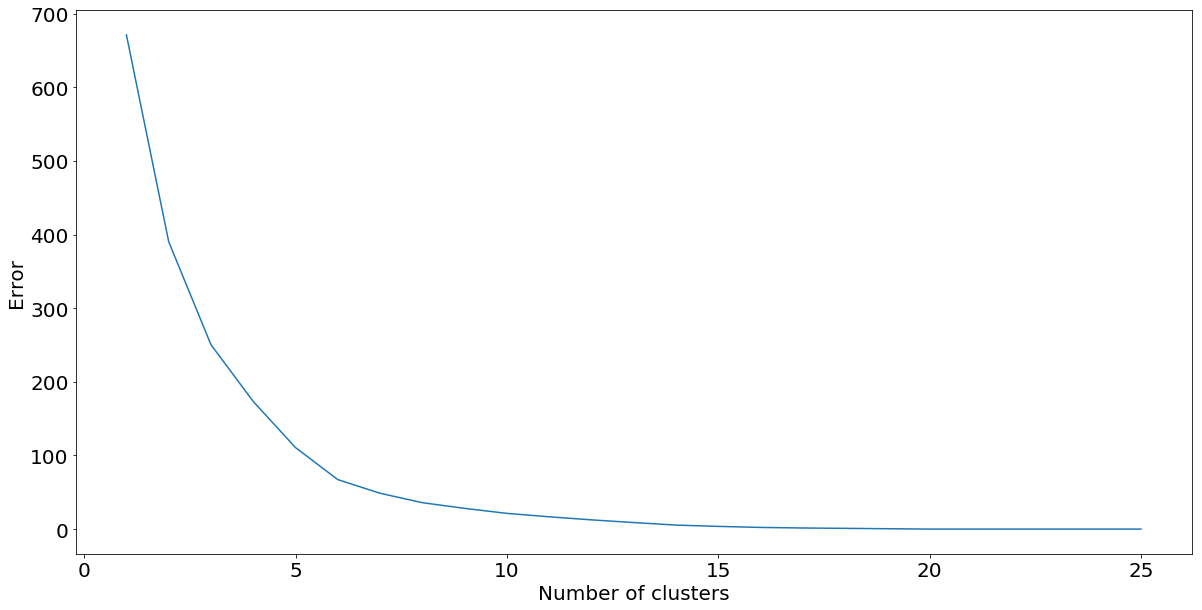

In [16]:
Feature_vector_pre911 = Feature_vector[Feature_vector.pre911_Weapons.notnull()]
Feature_vector_pre911 = Feature_vector_pre911.reset_index()
#Creates error for kmeans
evaluate_clusters(Feature_vector_pre911['pre911_Weapons'].tolist(), 25)

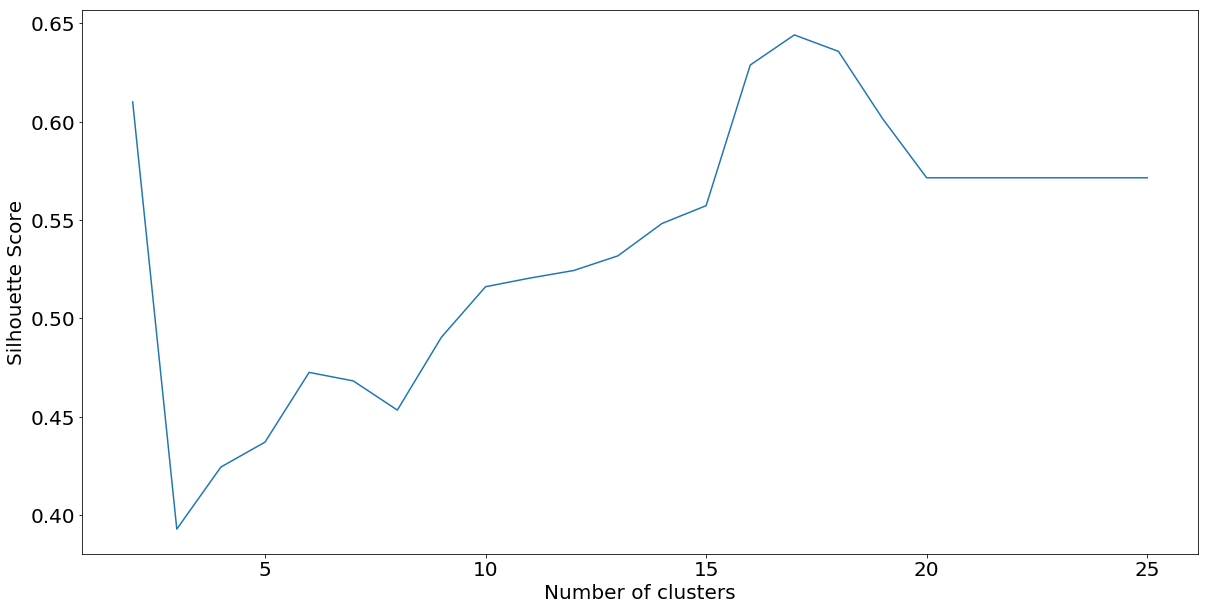

In [17]:
#Creates Silhouette Score for kmeans
sc_evaluate_clusters(Feature_vector_pre911['pre911_Weapons'].tolist(),25) 

In [18]:
# Creates kmeans fit, labeling, and centroids
kmeans = KMeans(init='k-means++', n_clusters=17, n_init=100)
kmeans.fit_predict(Feature_vector_pre911['pre911_Weapons'].tolist())
kmeans_centroids_pre911 = kmeans.cluster_centers_
kmeans_labels_pre911 = kmeans.labels_

Feature_vector_pre911['kmean_label_pre911'] = kmeans_labels_pre911

In [19]:
kmean_count = np.zeros(shape=(max(kmeans_labels_pre911)+1,len(weapons_list)))
for i in range(len(kmeans_labels_pre911)):
    kmean_count[kmeans_labels_pre911[i]] = kmean_count[kmeans_labels_pre911[i]] + Feature_vector_pre911['pre911_Weapons'][i]

kmean_legend_pre911 = []
for m in kmean_count:
    max_index = [i for i, j in enumerate(m) if j == max(m)]
    kmean_legend_pre911.append(weapons_list[max_index[0]])

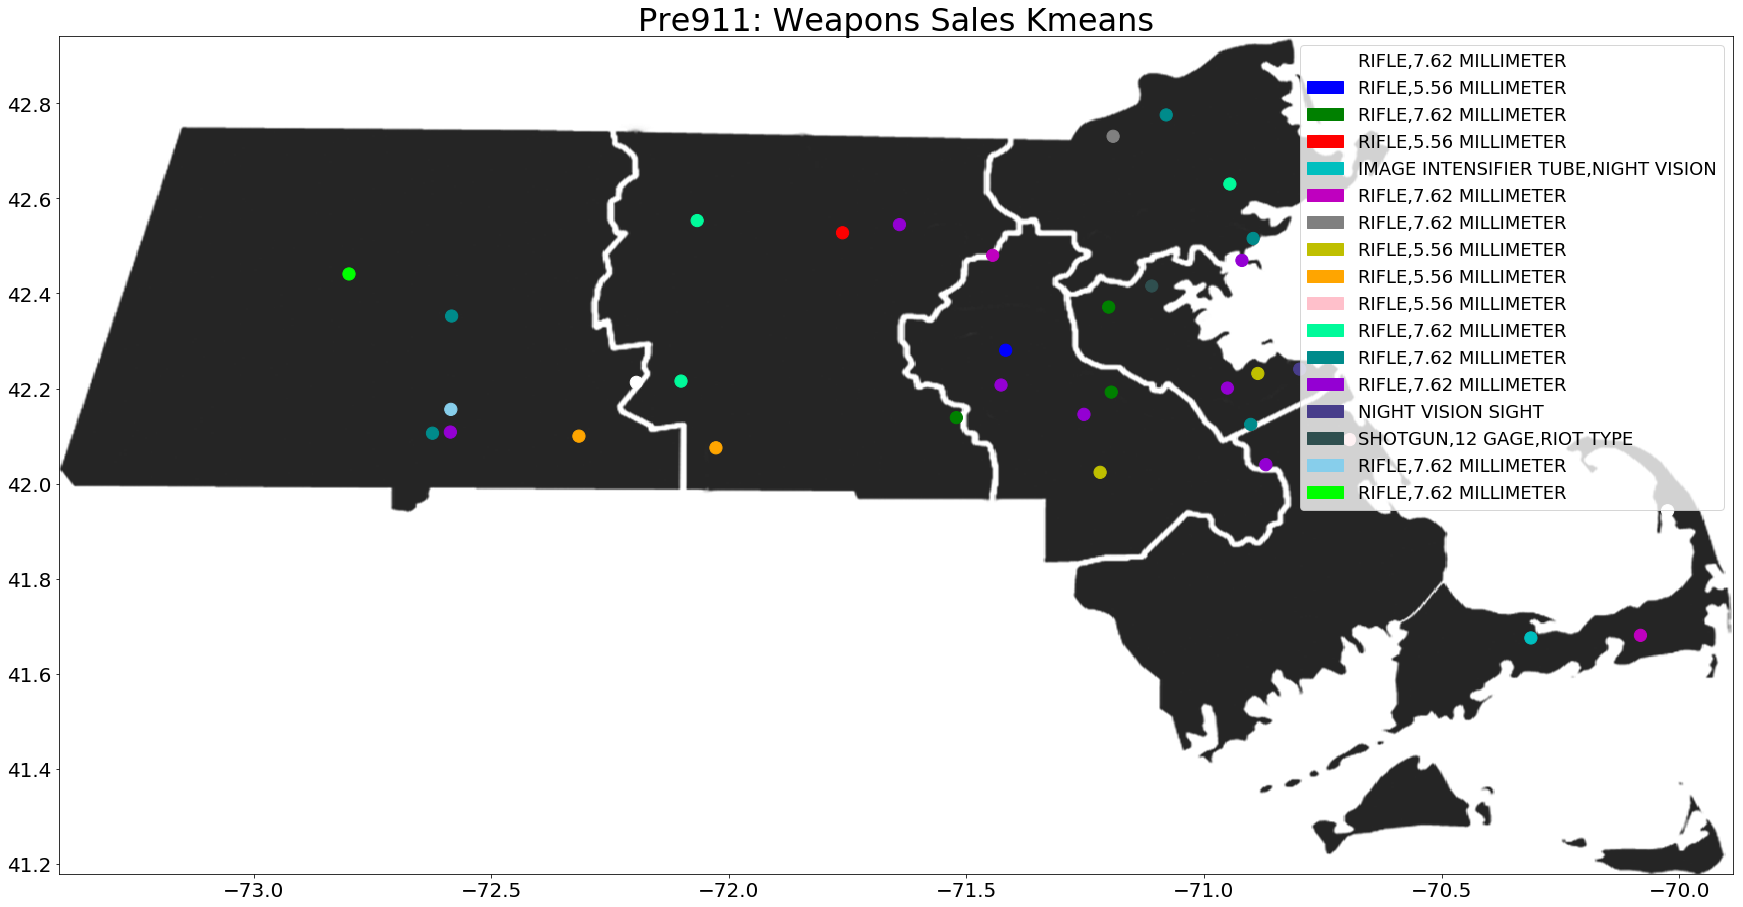

In [21]:
# Generates Cluster Graph
fig, ax = plt.subplots()
img =plt.imread('massachusetts.png')
ax.imshow(img,extent=[min(Feature_vector.longitude)-.2,max(Feature_vector.longitude)+.1,min(Feature_vector.latitude)-.4,max(Feature_vector.latitude)+.1])

plt.title('Pre911: Weapons Sales Kmeans', {'fontsize':32})
plt.rcParams["figure.figsize"] = (30,20)
plt.xticks(size=20)
plt.yticks(size=20)
cols = [matplotlib_colors[p] for p in Feature_vector_pre911['kmean_label_pre911']]
plt.scatter(Feature_vector_pre911['longitude'], Feature_vector_pre911['latitude'], s=150, c=cols)

kmean_handles_pre911 = []
for i in range(0,len(kmean_legend_pre911)):
    clusternum = 'cluster' + str(i)
    line = clusternum + ' = pat.Patch(color =  matplotlib_colors[' + str(i) + '], label = kmean_legend_pre911[' + str(i) + '])'
    exec(line)
    kmean_handles_pre911.append(eval(clusternum))

plt.legend(handles = kmean_handles_pre911, prop={'size': 18})
plt.show()
fig.savefig('Pre911_kmeans.png')

## post 9/11

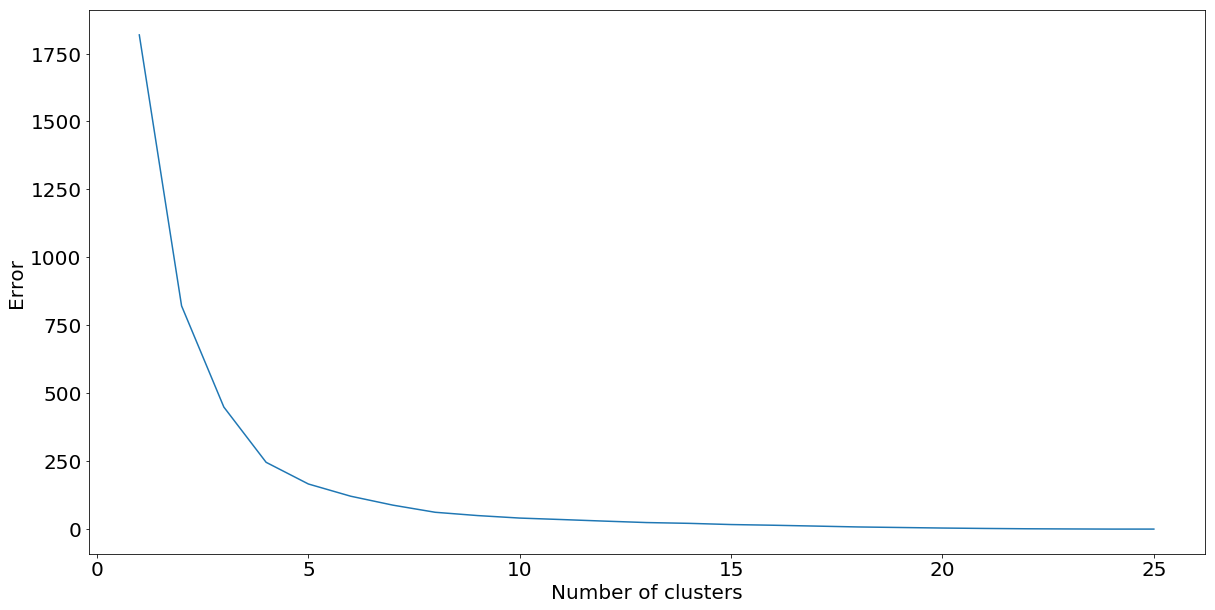

In [22]:
Feature_vector_post911 = Feature_vector[Feature_vector.post911_Weapons.notnull()]
Feature_vector_post911 = Feature_vector_post911.reset_index()
#Creates error for kmeans
evaluate_clusters(Feature_vector_post911['post911_Weapons'].tolist(), 25)

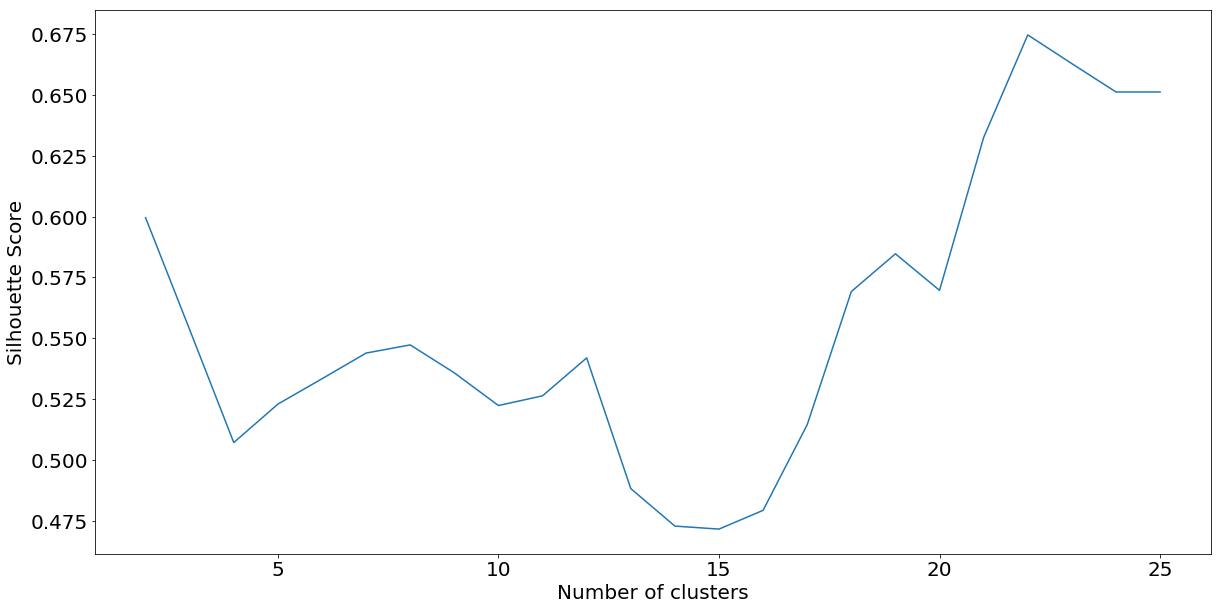

In [23]:
#Creates Silhouette Score for kmeans
sc_evaluate_clusters(Feature_vector_post911['post911_Weapons'].tolist(),25) 

In [24]:
# Creates kmeans fit, labeling, and centroids
kmeans = KMeans(init='k-means++', n_clusters=22, n_init=100)
kmeans.fit_predict(Feature_vector_post911['post911_Weapons'].tolist())
kmeans_centroids_post911 = kmeans.cluster_centers_
kmeans_labels_post911 = kmeans.labels_

Feature_vector_post911['kmean_label_post911'] = kmeans_labels_post911

In [25]:
kmean_count = np.zeros(shape=(max(kmeans_labels_post911)+1,len(weapons_list)))
for i in range(len(kmeans_labels_post911)):
    kmean_count[kmeans_labels_post911[i]] = kmean_count[kmeans_labels_post911[i]] + Feature_vector_post911['post911_Weapons'][i]

kmean_legend_post911 = []
for m in kmean_count:
    max_index = [i for i, j in enumerate(m) if j == max(m)]
    kmean_legend_post911.append(weapons_list[max_index[0]])

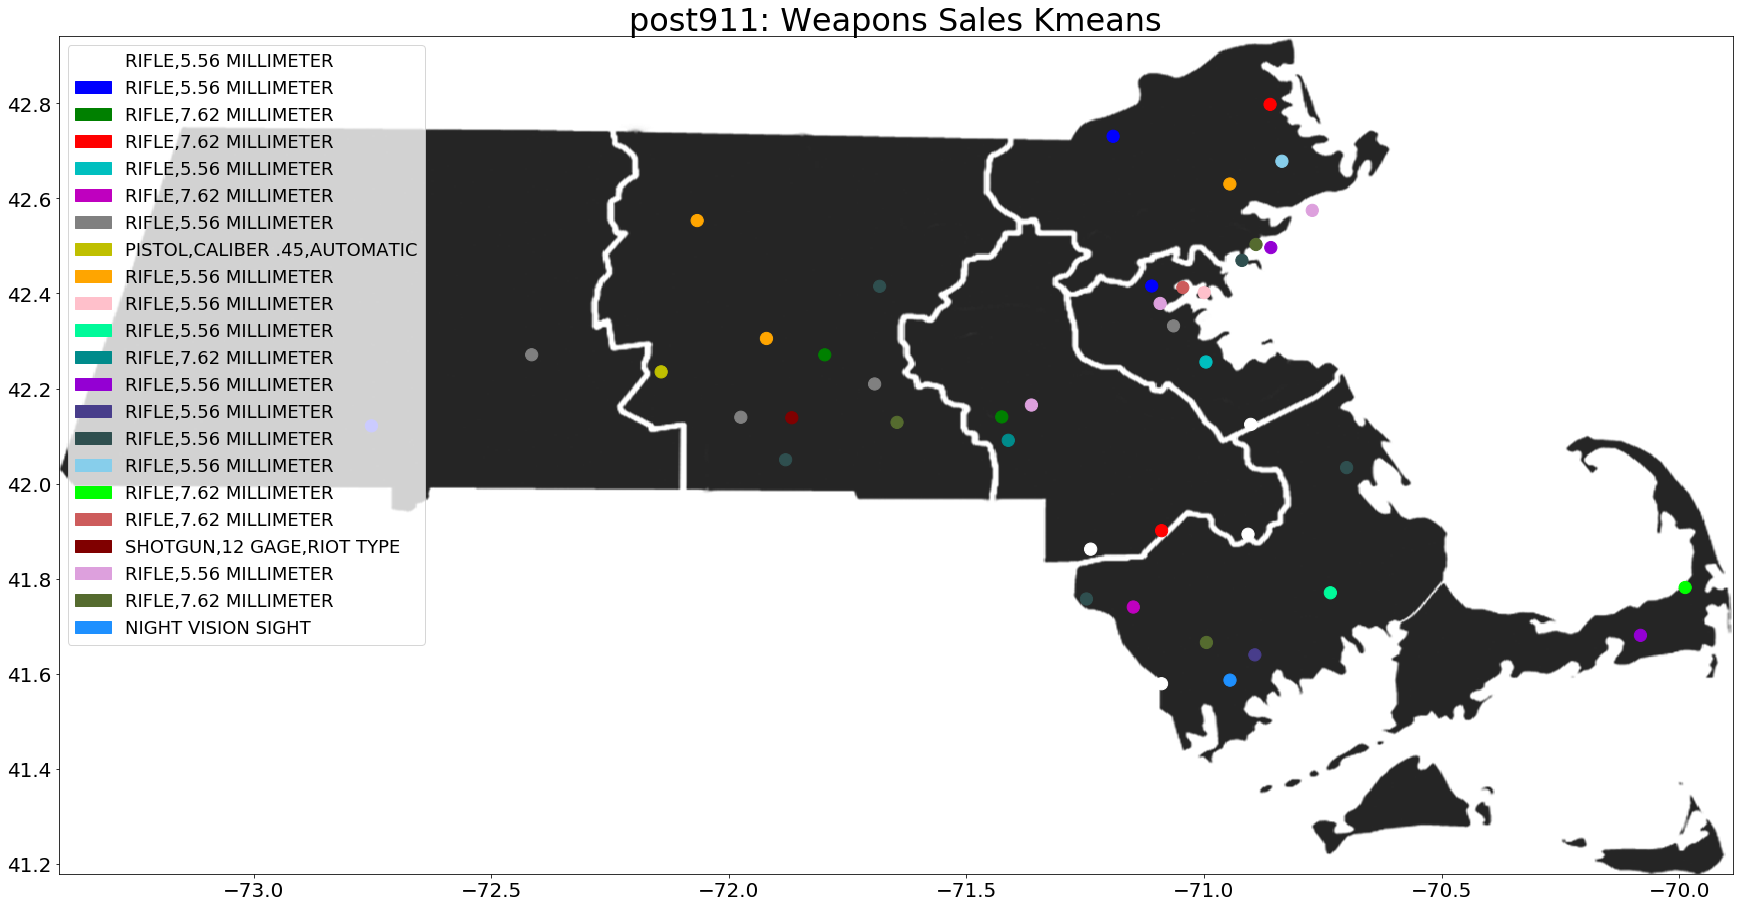

In [26]:
# Generates Cluster Graph
fig, ax = plt.subplots()
img =plt.imread('massachusetts.png')
ax.imshow(img,extent=[min(Feature_vector.longitude)-.2,max(Feature_vector.longitude)+.1,min(Feature_vector.latitude)-.4,max(Feature_vector.latitude)+.1])

plt.title('post911: Weapons Sales Kmeans', {'fontsize':32})
plt.rcParams["figure.figsize"] = (30,20)
plt.xticks(size=20)
plt.yticks(size=20)
cols = [matplotlib_colors[p] for p in Feature_vector_post911['kmean_label_post911']]
plt.scatter(Feature_vector_post911['longitude'], Feature_vector_post911['latitude'], s=150, c=cols)

kmean_handles_post911 = []
for i in range(0,len(kmean_legend_post911)):
    clusternum = 'cluster' + str(i)
    line = clusternum + ' = pat.Patch(color =  matplotlib_colors[' + str(i) + '], label = kmean_legend_post911[' + str(i) + '])'
    exec(line)
    kmean_handles_post911.append(eval(clusternum))

plt.legend(handles = kmean_handles_post911, prop={'size': 18})
plt.show()
fig.savefig('Post911_kmeans.png')

## 2010+

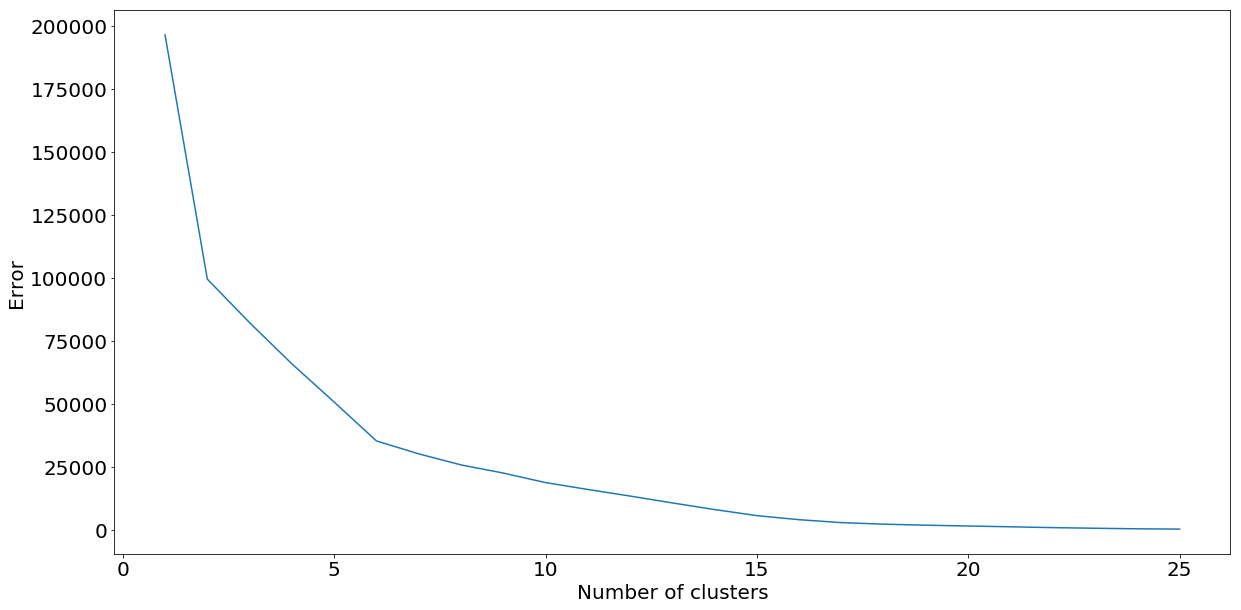

In [27]:
Feature_vector_plus2010 = Feature_vector[Feature_vector.plus2010_Weapons.notnull()]
Feature_vector_plus2010 = Feature_vector_plus2010.reset_index()
#Creates error for kmeans
evaluate_clusters(Feature_vector_plus2010['plus2010_Weapons'].tolist(), 25)

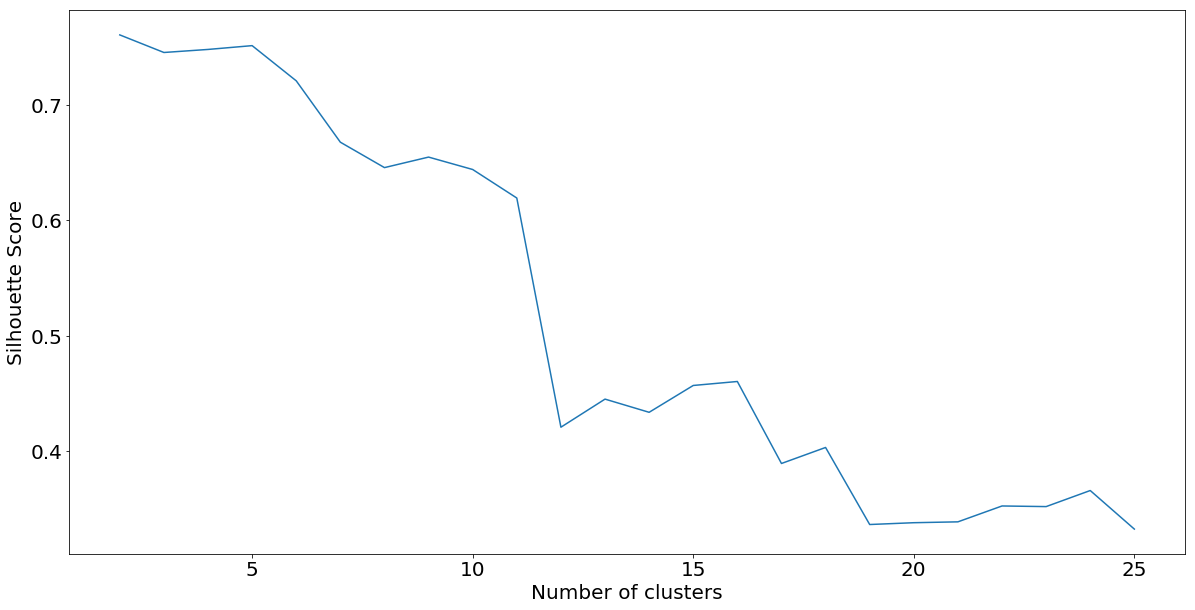

In [28]:
#Creates Silhouette Score for kmeans
sc_evaluate_clusters(Feature_vector_plus2010['plus2010_Weapons'].tolist(),25) 

In [29]:
# Creates kmeans fit, labeling, and centroids
kmeans = KMeans(init='k-means++', n_clusters=12, n_init=100)
kmeans.fit_predict(Feature_vector_plus2010['plus2010_Weapons'].tolist())
kmeans_centroids_plus2010 = kmeans.cluster_centers_
kmeans_labels_plus2010 = kmeans.labels_

Feature_vector_plus2010['kmean_label_plus2010'] = kmeans_labels_plus2010

In [30]:
kmean_count = np.zeros(shape=(max(kmeans_labels_plus2010)+1,len(weapons_list)))
for i in range(len(kmeans_labels_plus2010)):
    kmean_count[kmeans_labels_plus2010[i]] = kmean_count[kmeans_labels_plus2010[i]] + Feature_vector_plus2010['plus2010_Weapons'][i]

kmean_legend_plus2010 = []
for m in kmean_count:
    max_index = [i for i, j in enumerate(m) if j == max(m)]
    kmean_legend_plus2010.append(weapons_list[max_index[0]])

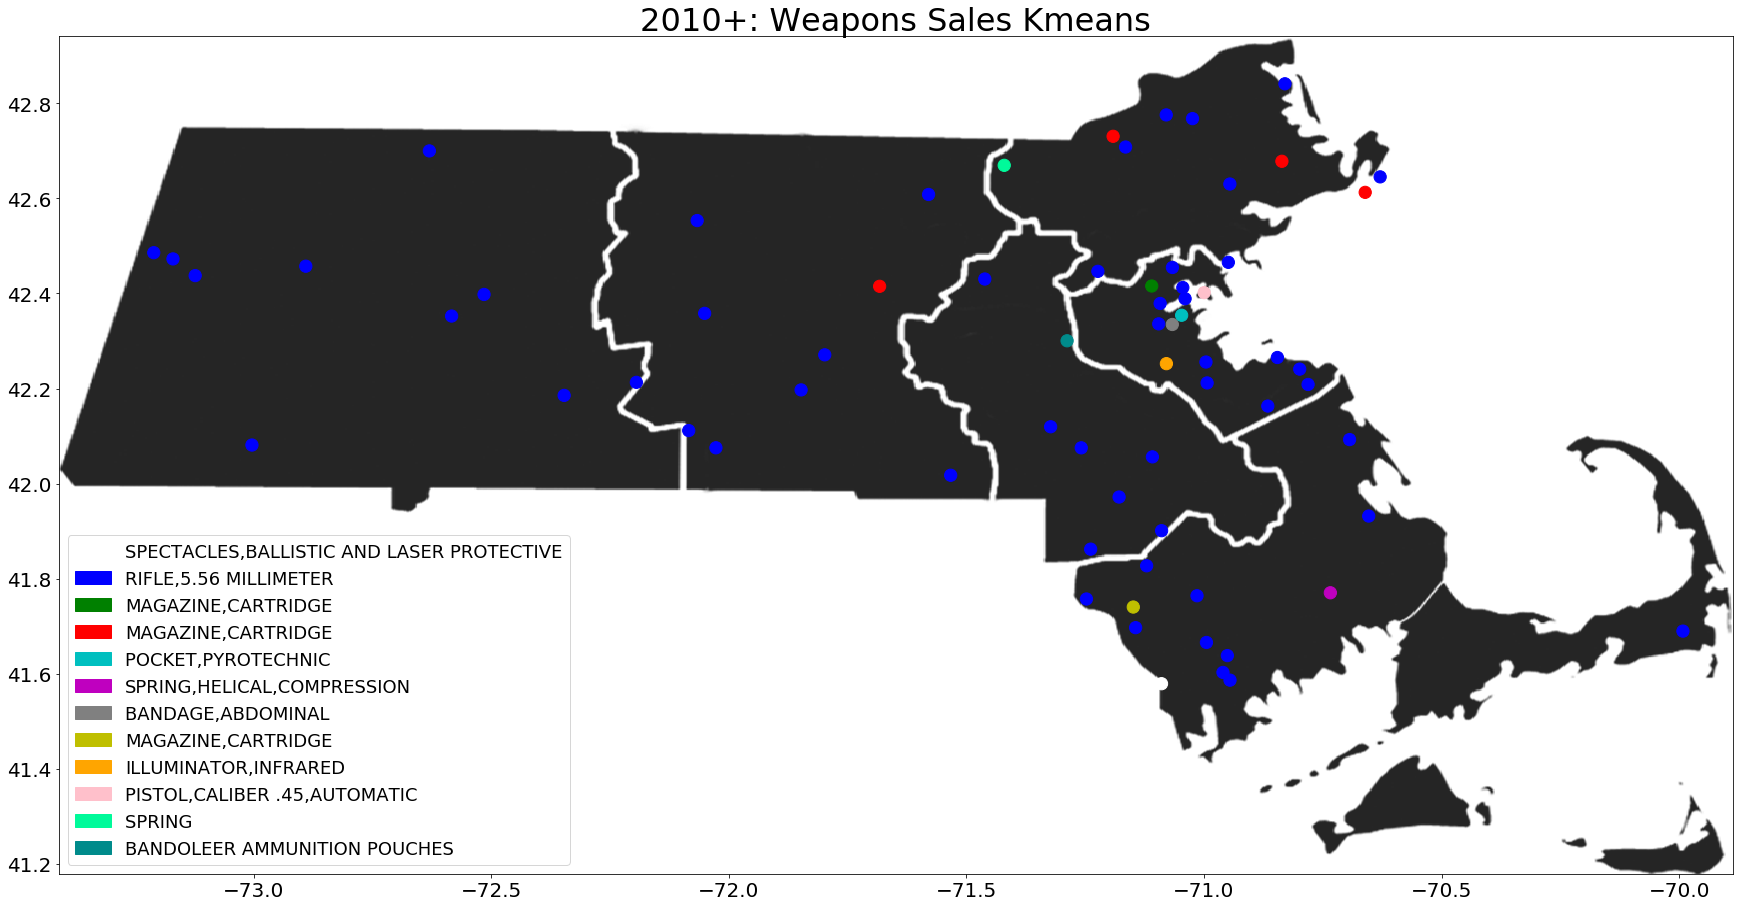

In [31]:
# Generates Cluster Graph
fig, ax = plt.subplots()
img =plt.imread('massachusetts.png')
ax.imshow(img,extent=[min(Feature_vector.longitude)-.2,max(Feature_vector.longitude)+.1,min(Feature_vector.latitude)-.4,max(Feature_vector.latitude)+.1])

plt.title('2010+: Weapons Sales Kmeans', {'fontsize':32})
plt.rcParams["figure.figsize"] = (30,20)
plt.xticks(size=20)
plt.yticks(size=20)
cols = [matplotlib_colors[p] for p in Feature_vector_plus2010['kmean_label_plus2010']]
plt.scatter(Feature_vector_plus2010['longitude'], Feature_vector_plus2010['latitude'], s=150, c=cols)

kmean_handles_plus2010 = []
for i in range(0,len(kmean_legend_plus2010)):
    clusternum = 'cluster' + str(i)
    line = clusternum + ' = pat.Patch(color =  matplotlib_colors[' + str(i) + '], label = kmean_legend_plus2010[' + str(i) + '])'
    exec(line)
    kmean_handles_plus2010.append(eval(clusternum))

plt.legend(handles = kmean_handles_plus2010, prop={'size': 18})
plt.show()
fig.savefig('2010plus_kmeans.png')

# Hierarchy

## pre 9/11

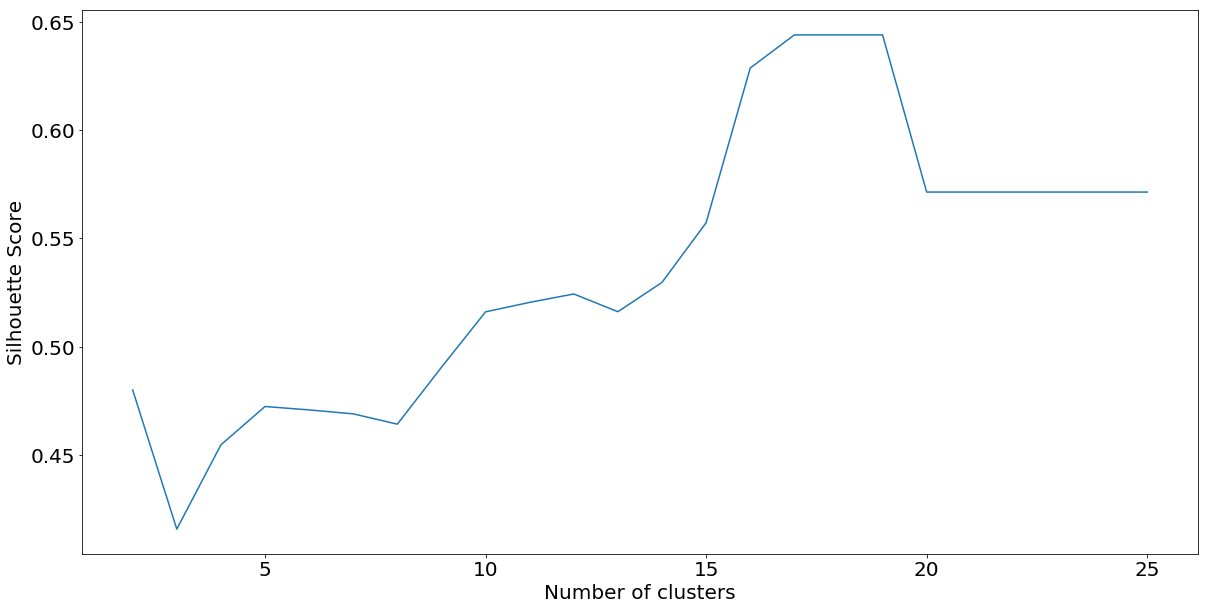

In [32]:
#Creates Silhouette Score for hierarchy
Z = hierarchy.linkage(Feature_vector_pre911['pre911_Weapons'].tolist(), method='ward', metric='euclidean')
sc_evaluate_clusters_heir(Z,Feature_vector_pre911['pre911_Weapons'].tolist(),25)

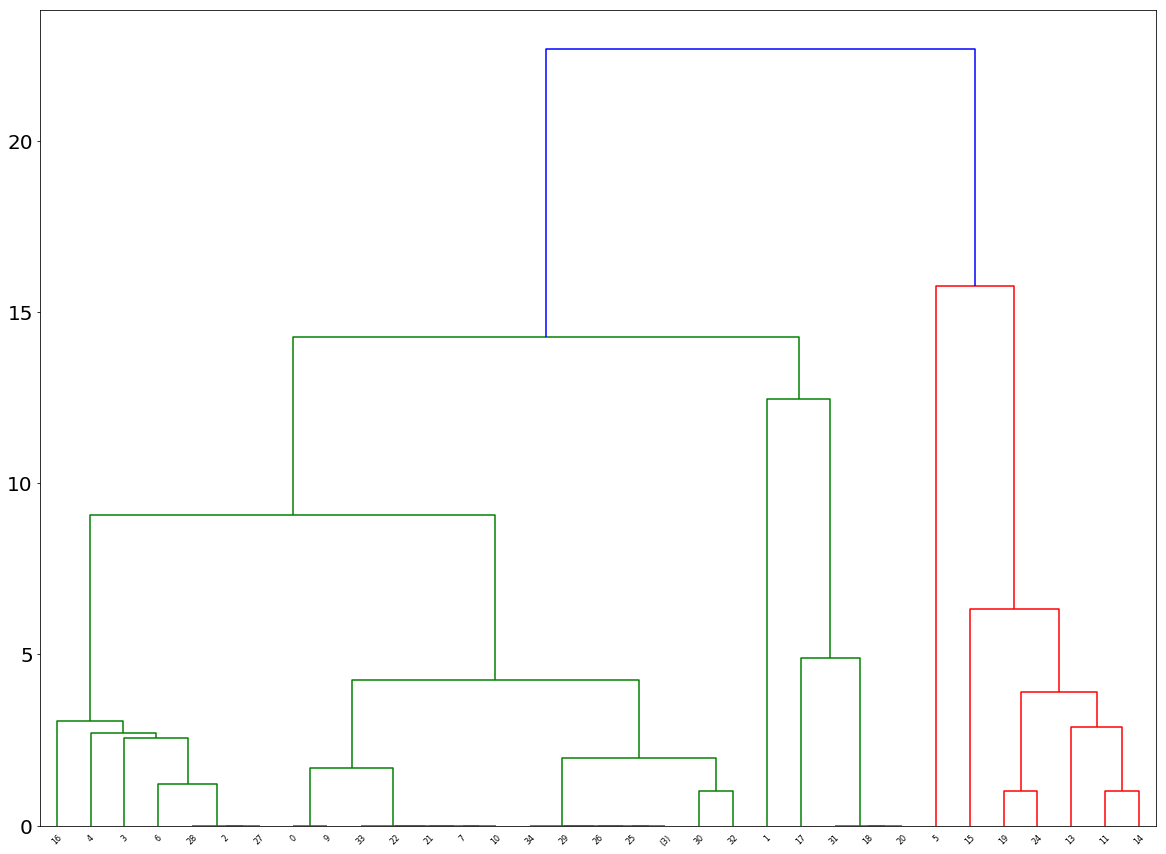

In [33]:
#Creates Dendogram
plt.figure(figsize=(20,15))
plt.xticks(size=20)
plt.yticks(size=20)
R = hierarchy.dendrogram(Z, p=8, truncate_mode='level', show_leaf_counts=True)

In [34]:
# Creates hierarchy fit and labeling
hier_labels_pre911 = hierarchy.fcluster(Z, 2, criterion='maxclust')
Feature_vector_pre911['hier_label_pre911'] = hier_labels_pre911

In [35]:
hier_count = np.zeros(shape=(max(hier_labels_pre911)+1,len(weapons_list)))
for i in range(len(hier_labels_pre911)):
    hier_count[hier_labels_pre911[i]-1] = hier_count[hier_labels_pre911[i]-1] + Feature_vector_pre911['pre911_Weapons'][i]

hier_legend_pre911 = []
for m in hier_count:
    max_index = [i for i, j in enumerate(m) if j == max(m)]
    hier_legend_pre911.append(weapons_list[max_index[0]])

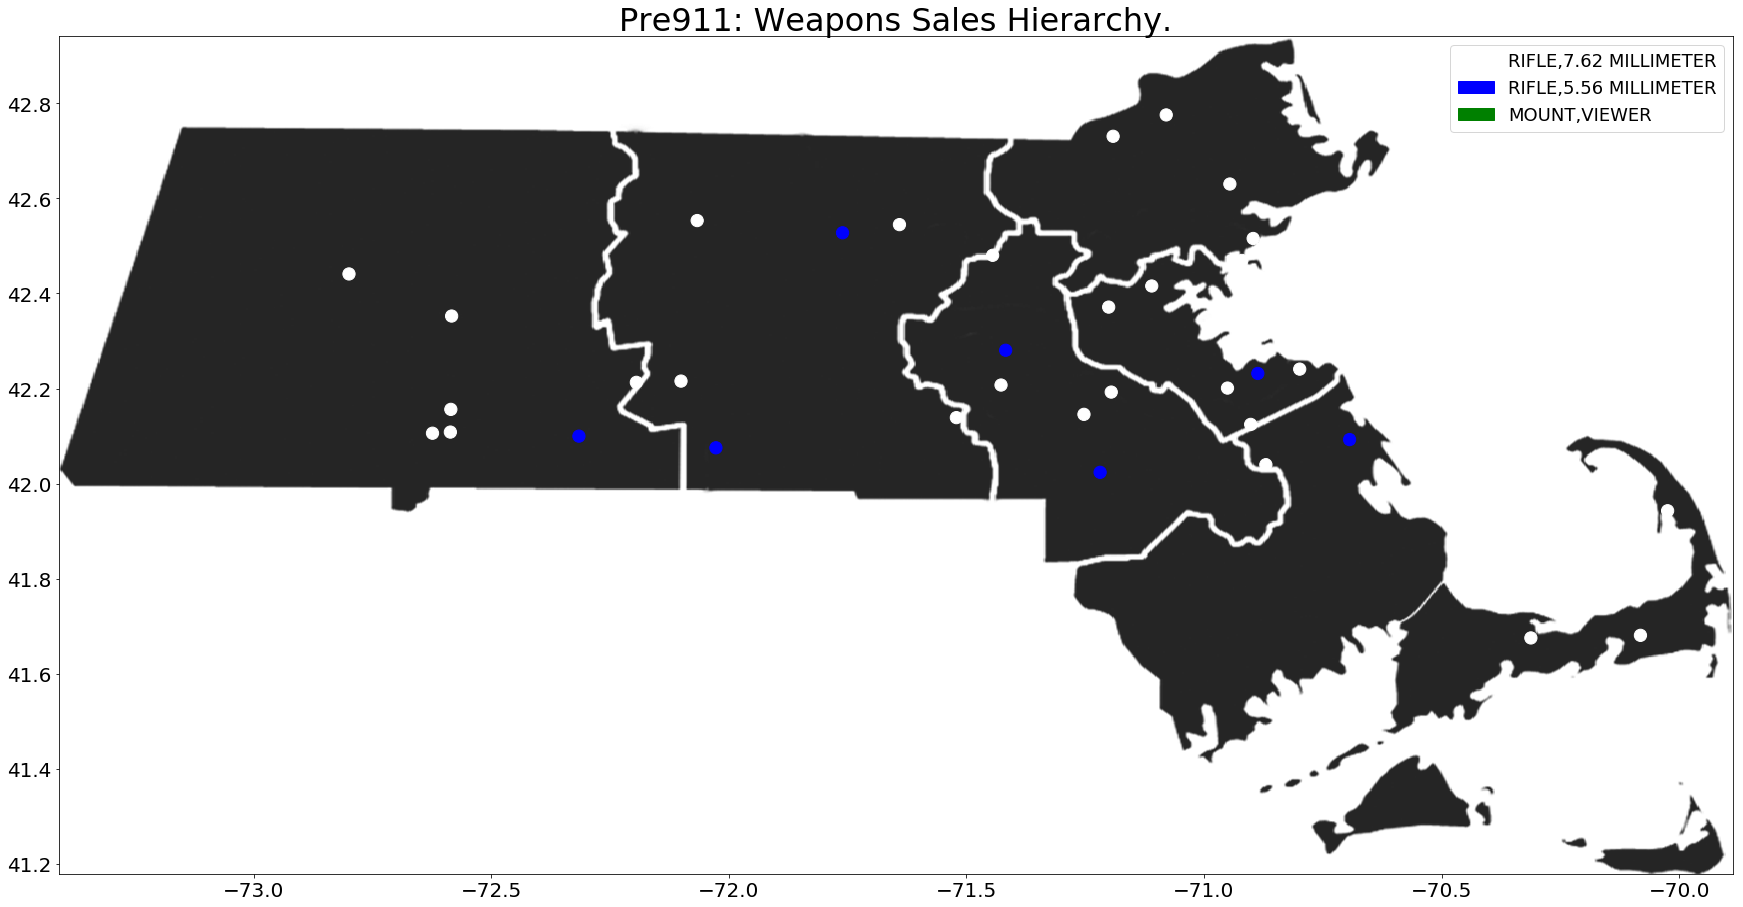

In [36]:
# Generates Cluster Graph
fig, ax = plt.subplots()
img =plt.imread('massachusetts.png')
ax.imshow(img,extent=[min(Feature_vector.longitude)-.2,max(Feature_vector.longitude)+.1,min(Feature_vector.latitude)-.4,max(Feature_vector.latitude)+.1])

plt.title('Pre911: Weapons Sales Hierarchy.', {'fontsize':32})
plt.rcParams["figure.figsize"] = (30,20)
plt.xticks(size=20)
plt.yticks(size=20)
cols = [matplotlib_colors[p-1] for p in Feature_vector_pre911['hier_label_pre911']]
plt.scatter(Feature_vector_pre911['longitude'], Feature_vector_pre911['latitude'], s=150, c=cols)

hier_handles_pre911 = []
for i in range(0,len(hier_legend_pre911)):
    clusternum = 'cluster' + str(i)
    line = clusternum + ' = pat.Patch(color =  matplotlib_colors[' + str(i) + '], label = hier_legend_pre911[' + str(i) + '])'
    exec(line)
    hier_handles_pre911.append(eval(clusternum))

plt.legend(handles = hier_handles_pre911, prop={'size': 18})
plt.show()
fig.savefig('Pre911_hier.png')

## Post 9/11

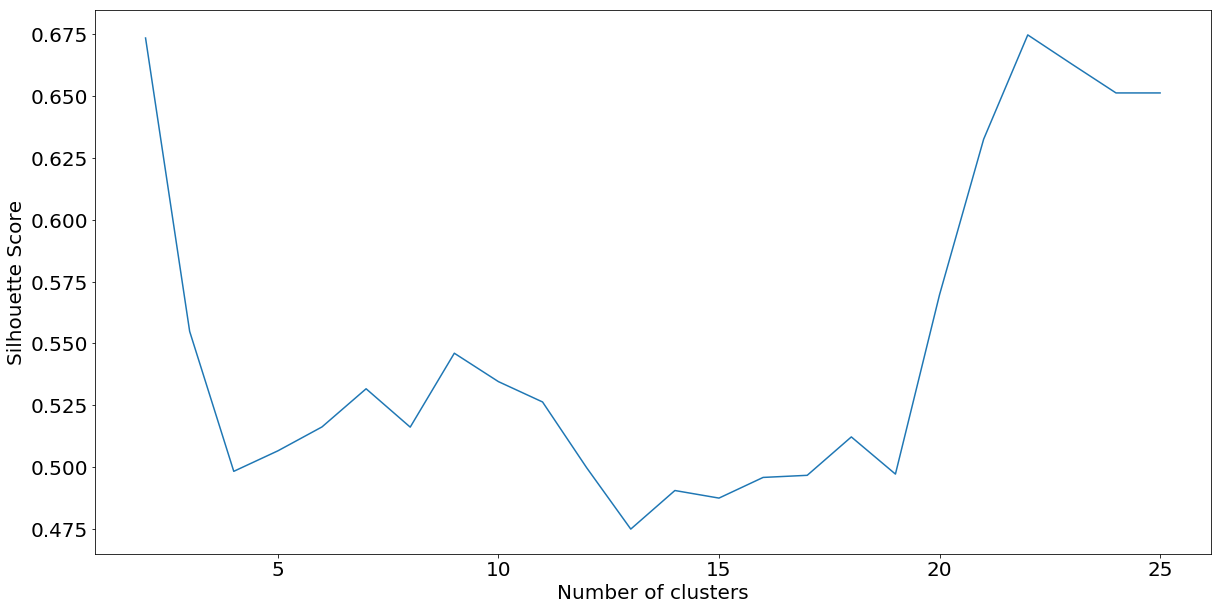

In [37]:
#Creates Silhouette Score for hierarchy
Z = hierarchy.linkage(Feature_vector_post911['post911_Weapons'].tolist(), method='ward', metric='euclidean')
sc_evaluate_clusters_heir(Z,Feature_vector_post911['post911_Weapons'].tolist(),25)

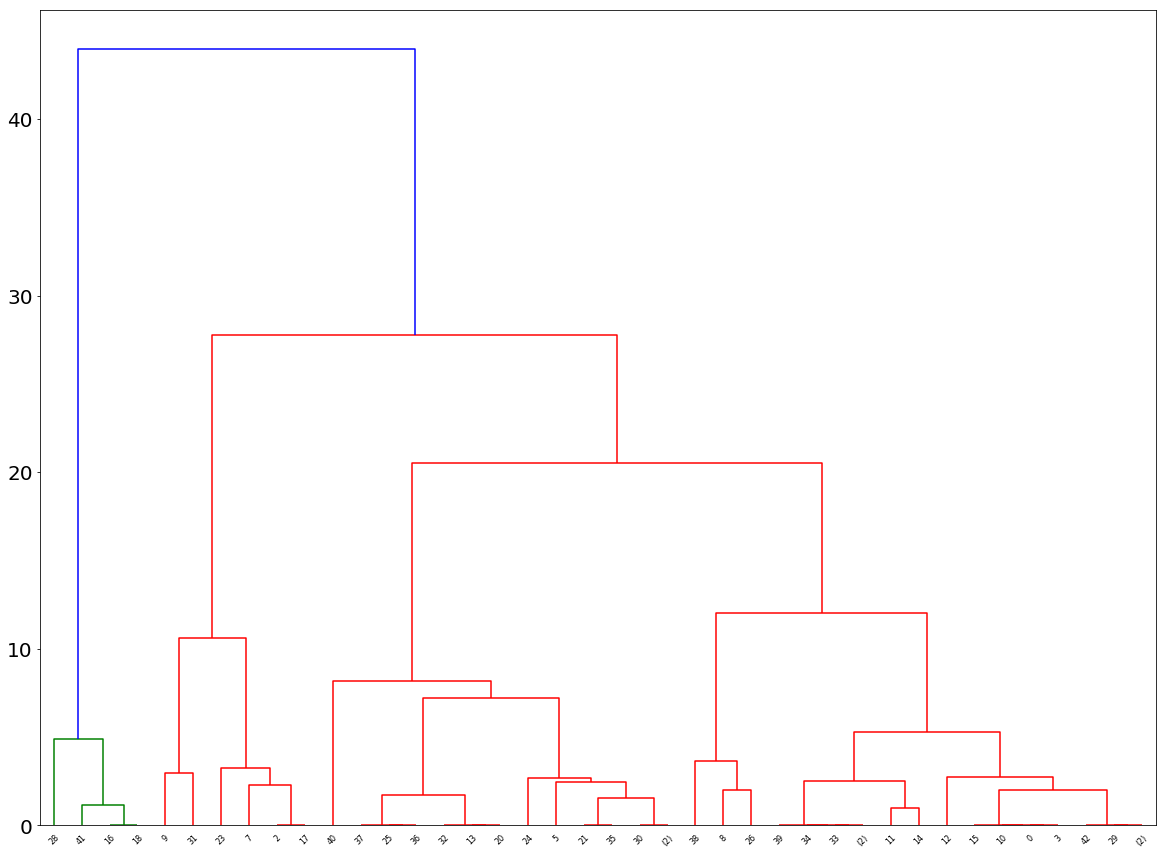

In [38]:
#Creates Dendogram
plt.figure(figsize=(20,15))
plt.xticks(size=20)
plt.yticks(size=20)
R = hierarchy.dendrogram(Z, p=8, truncate_mode='level', show_leaf_counts=True)

In [39]:
# Creates hierarchy fit and labeling
hier_labels_post911 = hierarchy.fcluster(Z, 2, criterion='maxclust')
Feature_vector_post911['hier_label_post911'] = hier_labels_post911

In [40]:
hier_count = np.zeros(shape=(max(hier_labels_post911)+1,len(weapons_list)))
for i in range(len(hier_labels_post911)):
    hier_count[hier_labels_post911[i]-1] = hier_count[hier_labels_post911[i]-1] + Feature_vector_post911['post911_Weapons'][i]

hier_legend_post911 = []
for m in hier_count:
    max_index = [i for i, j in enumerate(m) if j == max(m)]
    hier_legend_post911.append(weapons_list[max_index[0]])

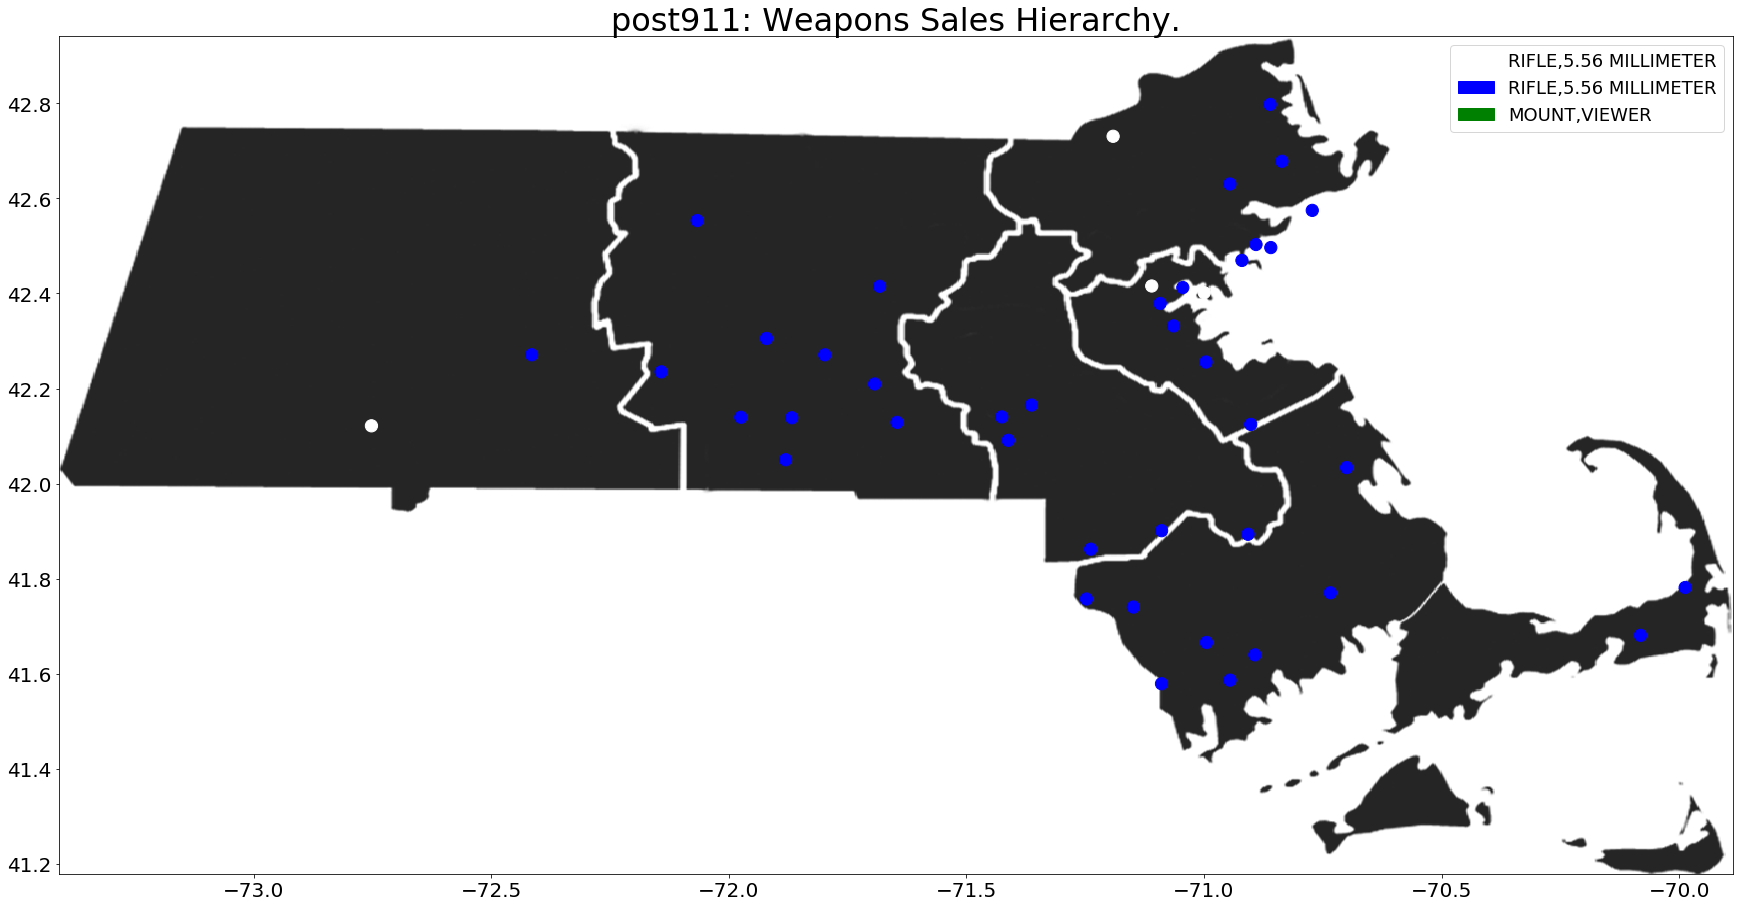

In [41]:
# Generates Cluster Graph
fig, ax = plt.subplots()
img =plt.imread('massachusetts.png')
ax.imshow(img,extent=[min(Feature_vector.longitude)-.2,max(Feature_vector.longitude)+.1,min(Feature_vector.latitude)-.4,max(Feature_vector.latitude)+.1])

plt.title('post911: Weapons Sales Hierarchy.', {'fontsize':32})
plt.rcParams["figure.figsize"] = (30,20)
plt.xticks(size=20)
plt.yticks(size=20)
cols = [matplotlib_colors[p-1] for p in Feature_vector_post911['hier_label_post911']]
plt.scatter(Feature_vector_post911['longitude'], Feature_vector_post911['latitude'], s=150, c=cols)

hier_handles_post911 = []
for i in range(0,len(hier_legend_post911)):
    clusternum = 'cluster' + str(i)
    line = clusternum + ' = pat.Patch(color =  matplotlib_colors[' + str(i) + '], label = hier_legend_post911[' + str(i) + '])'
    exec(line)
    hier_handles_post911.append(eval(clusternum))

plt.legend(handles = hier_handles_post911, prop={'size': 18})
plt.show()
fig.savefig('Post911_hier.png')

## 2010+

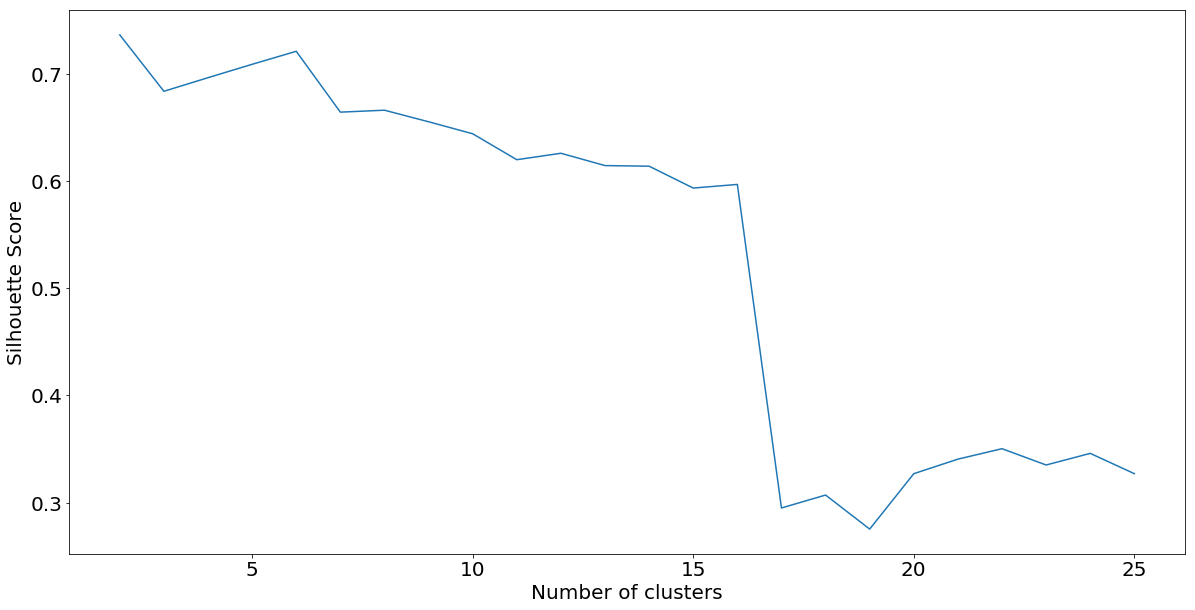

In [42]:
#Creates Silhouette Score for hierarchy
Z = hierarchy.linkage(Feature_vector_plus2010['plus2010_Weapons'].tolist(), method='ward', metric='euclidean')
sc_evaluate_clusters_heir(Z,Feature_vector_plus2010['plus2010_Weapons'].tolist(),25)

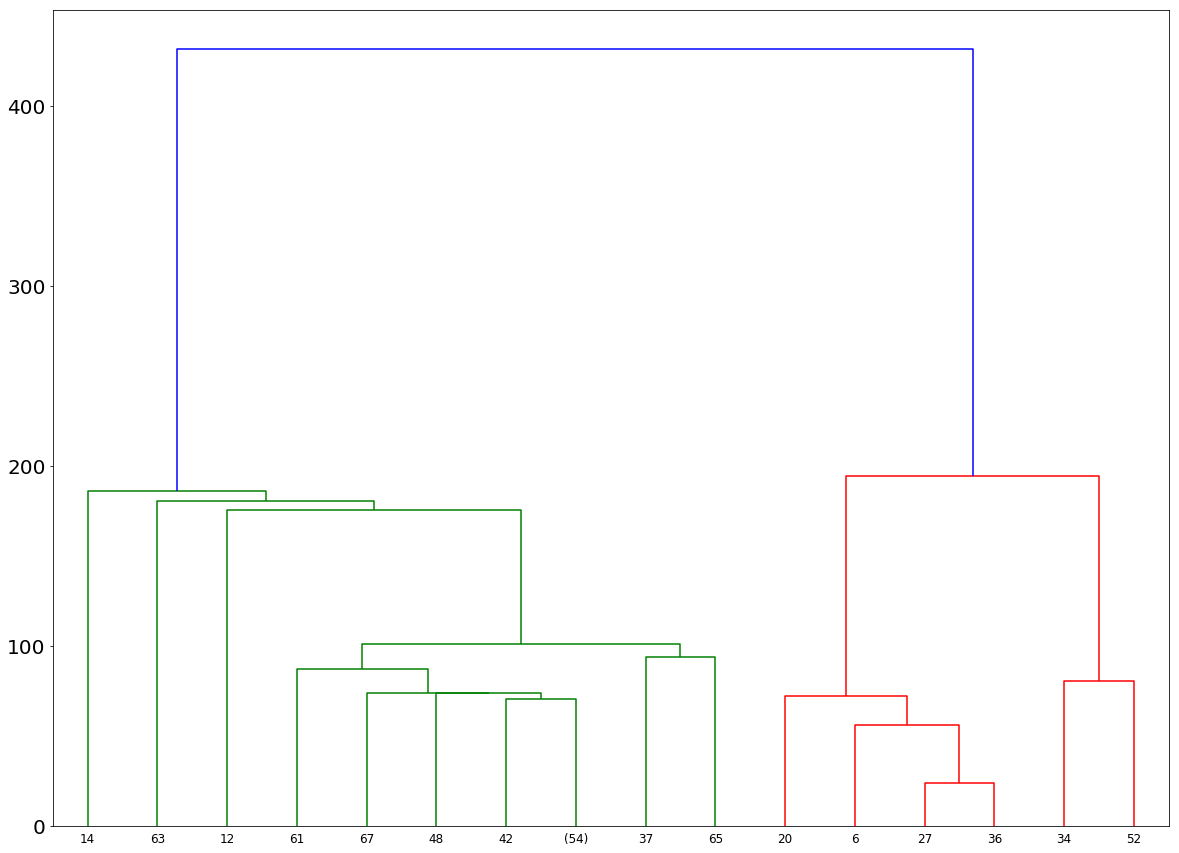

In [43]:
#Creates Dendogram
plt.figure(figsize=(20,15))
plt.xticks(size=20)
plt.yticks(size=20)
R = hierarchy.dendrogram(Z, p=8, truncate_mode='level', show_leaf_counts=True)

In [44]:
# Creates hierarchy fit and labeling
hier_labels_plus2010 = hierarchy.fcluster(Z, 2, criterion='maxclust')
Feature_vector_plus2010['hier_label_plus2010'] = hier_labels_plus2010

In [45]:
hier_count = np.zeros(shape=(max(hier_labels_plus2010)+1,len(weapons_list)))
for i in range(len(hier_labels_plus2010)):
    hier_count[hier_labels_plus2010[i]-1] = hier_count[hier_labels_plus2010[i]-1] + Feature_vector_plus2010['plus2010_Weapons'][i]

hier_legend_plus2010 = []
for m in hier_count:
    max_index = [i for i, j in enumerate(m) if j == max(m)]
    hier_legend_plus2010.append(weapons_list[max_index[0]])

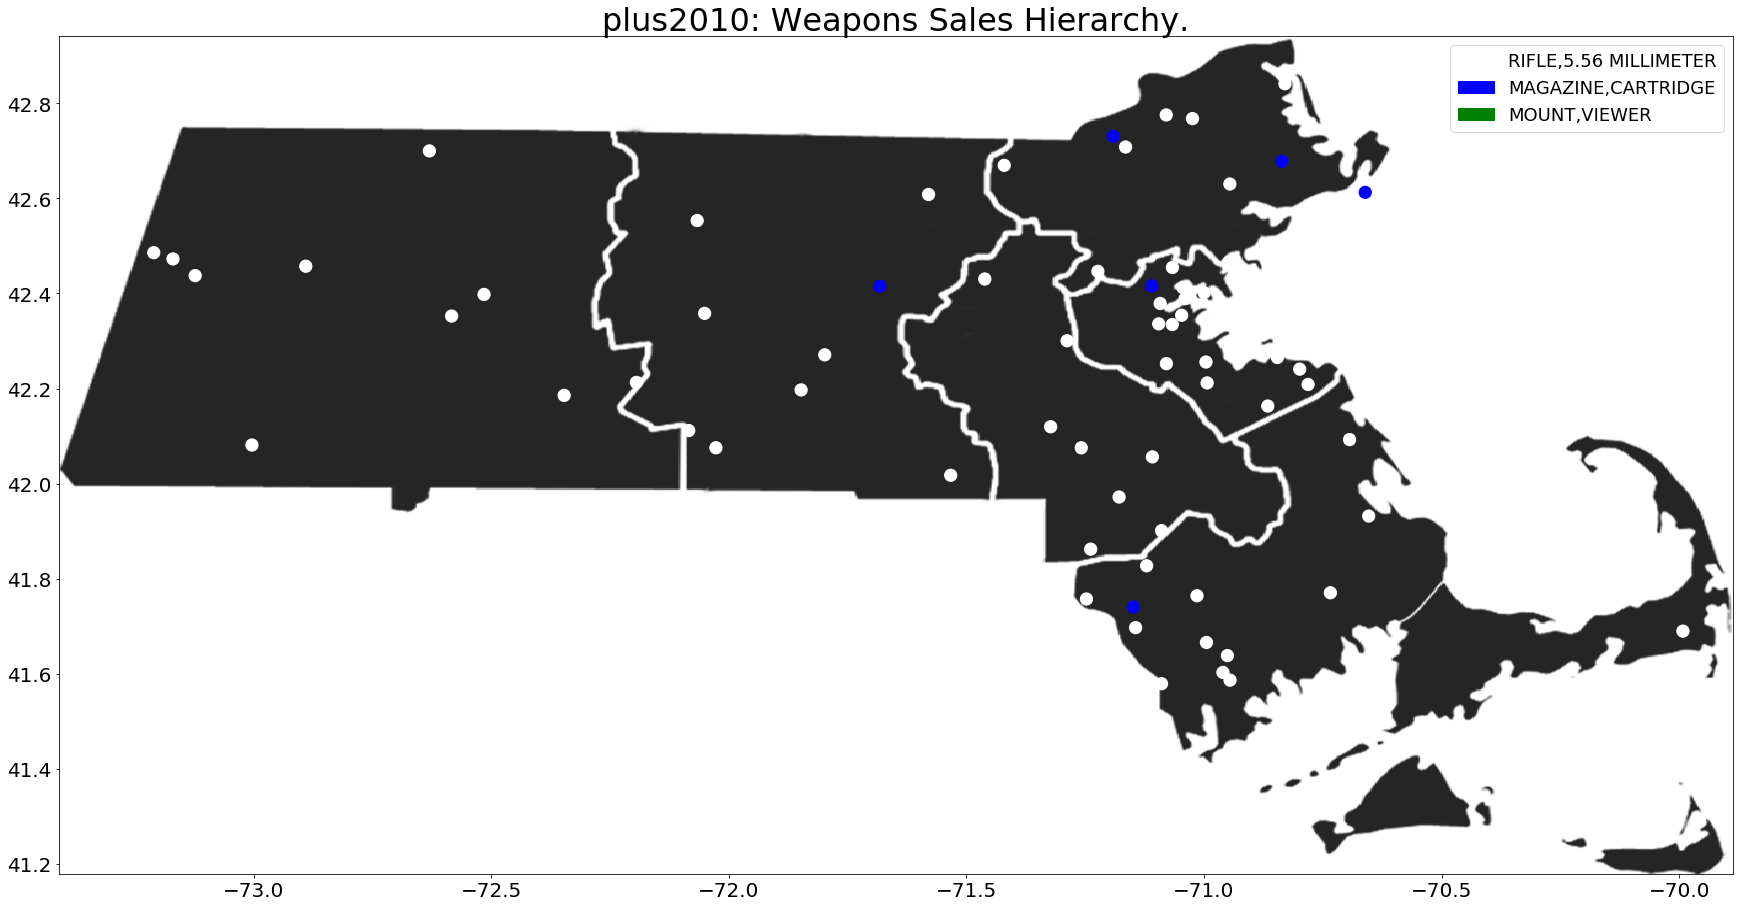

In [46]:
# Generates Cluster Graph
fig, ax = plt.subplots()
img =plt.imread('massachusetts.png')
ax.imshow(img,extent=[min(Feature_vector.longitude)-.2,max(Feature_vector.longitude)+.1,min(Feature_vector.latitude)-.4,max(Feature_vector.latitude)+.1])

plt.title('plus2010: Weapons Sales Hierarchy.', {'fontsize':32})
plt.rcParams["figure.figsize"] = (30,20)
plt.xticks(size=20)
plt.yticks(size=20)
cols = [matplotlib_colors[p-1] for p in Feature_vector_plus2010['hier_label_plus2010']]
plt.scatter(Feature_vector_plus2010['longitude'], Feature_vector_plus2010['latitude'], s=150, c=cols)

hier_handles_plus2010 = []
for i in range(0,len(hier_legend_plus2010)):
    clusternum = 'cluster' + str(i)
    line = clusternum + ' = pat.Patch(color =  matplotlib_colors[' + str(i) + '], label = hier_legend_plus2010[' + str(i) + '])'
    exec(line)
    hier_handles_plus2010.append(eval(clusternum))

plt.legend(handles = hier_handles_plus2010, prop={'size': 18})
plt.show()
fig.savefig('2010plus_hier.png')

# GMM

## Pre 9/11

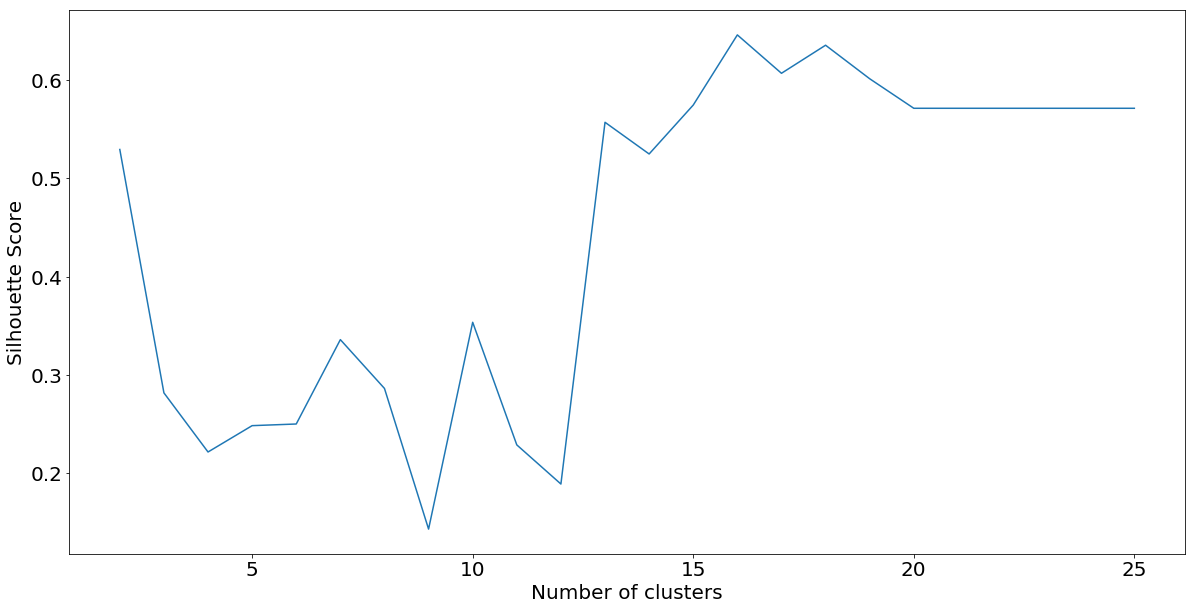

In [47]:
#Creates Silhouette Score for GMM
sc_evaluate_clusters_gmm(Feature_vector_pre911['pre911_Weapons'].tolist(),25) 

In [48]:
# Creates gmm fit, labeling, and centroids
gmm = mixture.GaussianMixture(n_components=16, covariance_type='full')
gmm.fit(Feature_vector_pre911['pre911_Weapons'].tolist())

gmm_labels_pre911 = gmm.predict(Feature_vector_pre911['pre911_Weapons'].tolist())
gmm_centroids_pre911 = gmm.means_

Feature_vector_pre911['gmm_label_pre911'] = gmm_labels_pre911

In [49]:
gmm_count = np.zeros(shape=(max(gmm_labels_pre911)+1,len(weapons_list)))
for i in range(len(gmm_labels_pre911)):
    gmm_count[gmm_labels_pre911[i]] = gmm_count[gmm_labels_pre911[i]] + Feature_vector_pre911['pre911_Weapons'][i]

gmm_legend_pre911 = []
for m in gmm_count:
    max_index = [i for i, j in enumerate(m) if j == max(m)]
    gmm_legend_pre911.append(weapons_list[max_index[0]])

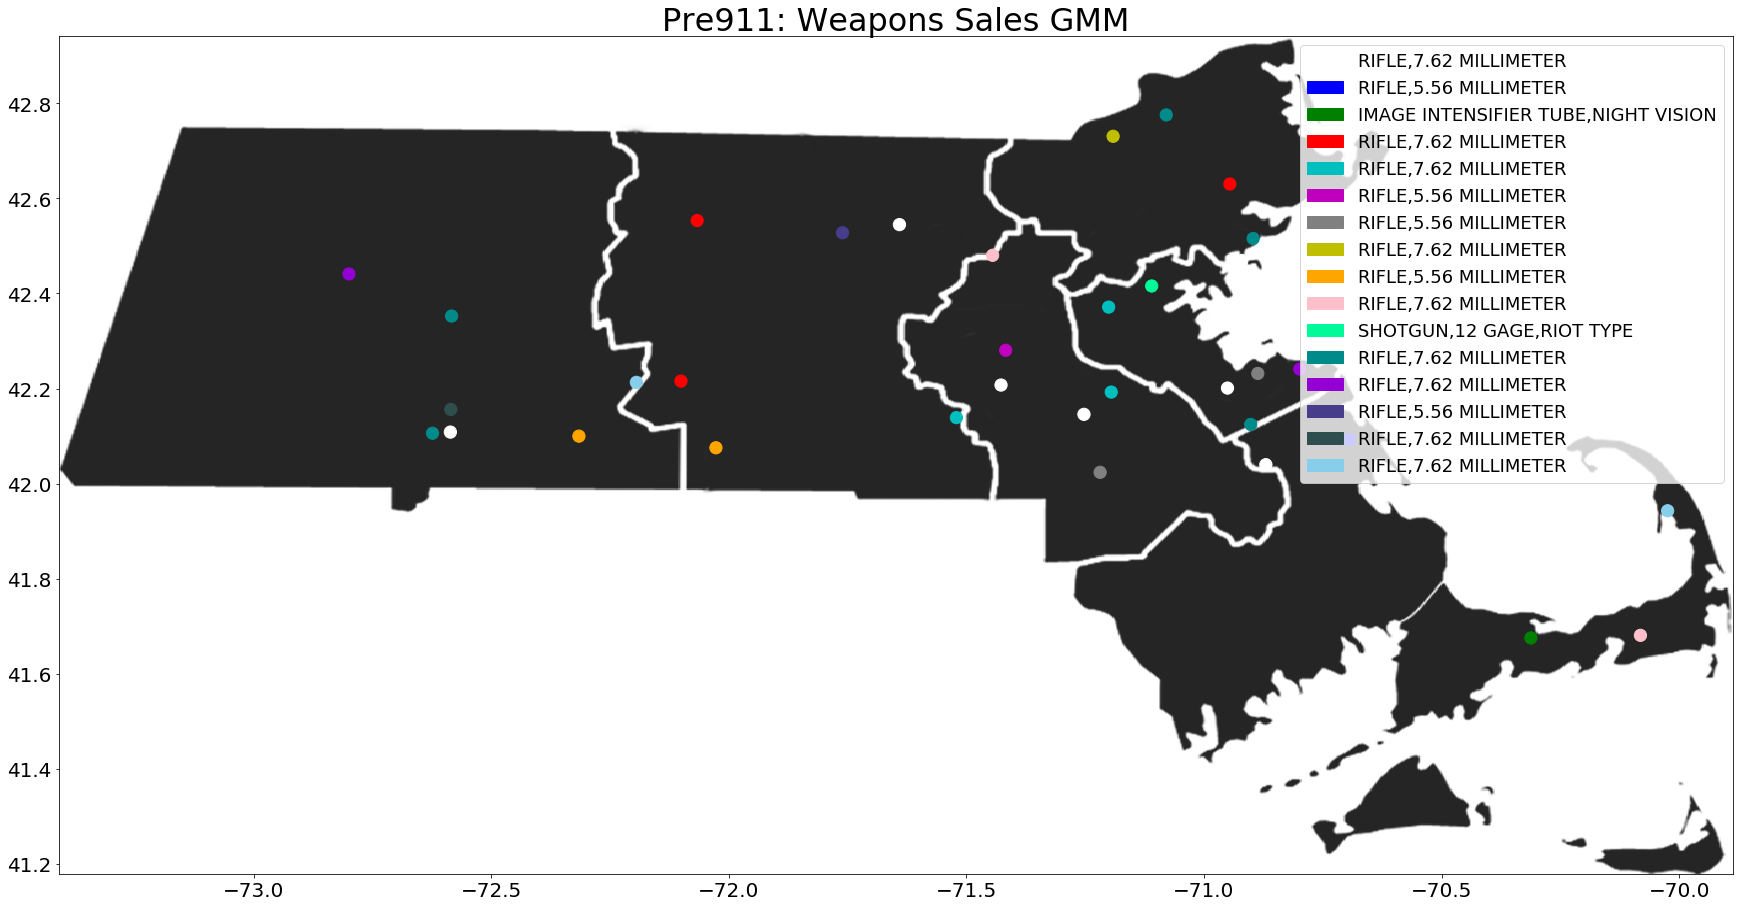

In [50]:
# Generates Cluster Graph
fig, ax = plt.subplots()
img =plt.imread('massachusetts.png')
ax.imshow(img,extent=[min(Feature_vector.longitude)-.2,max(Feature_vector.longitude)+.1,min(Feature_vector.latitude)-.4,max(Feature_vector.latitude)+.1])

plt.title('Pre911: Weapons Sales GMM', {'fontsize':32})
plt.rcParams["figure.figsize"] = (30,20)
plt.xticks(size=20)
plt.yticks(size=20)
cols = [matplotlib_colors[p] for p in Feature_vector_pre911['gmm_label_pre911']]
plt.scatter(Feature_vector_pre911['longitude'], Feature_vector_pre911['latitude'], s=150, c=cols)

gmm_handles_pre911 = []
for i in range(0,len(gmm_legend_pre911)):
    clusternum = 'cluster' + str(i)
    line = clusternum + ' = pat.Patch(color =  matplotlib_colors[' + str(i) + '], label = gmm_legend_pre911[' + str(i) + '])'
    exec(line)
    gmm_handles_pre911.append(eval(clusternum))

plt.legend(handles = gmm_handles_pre911, prop={'size': 18})
plt.show()
fig.savefig('Pre911_GMM.png')

## Post 9/11

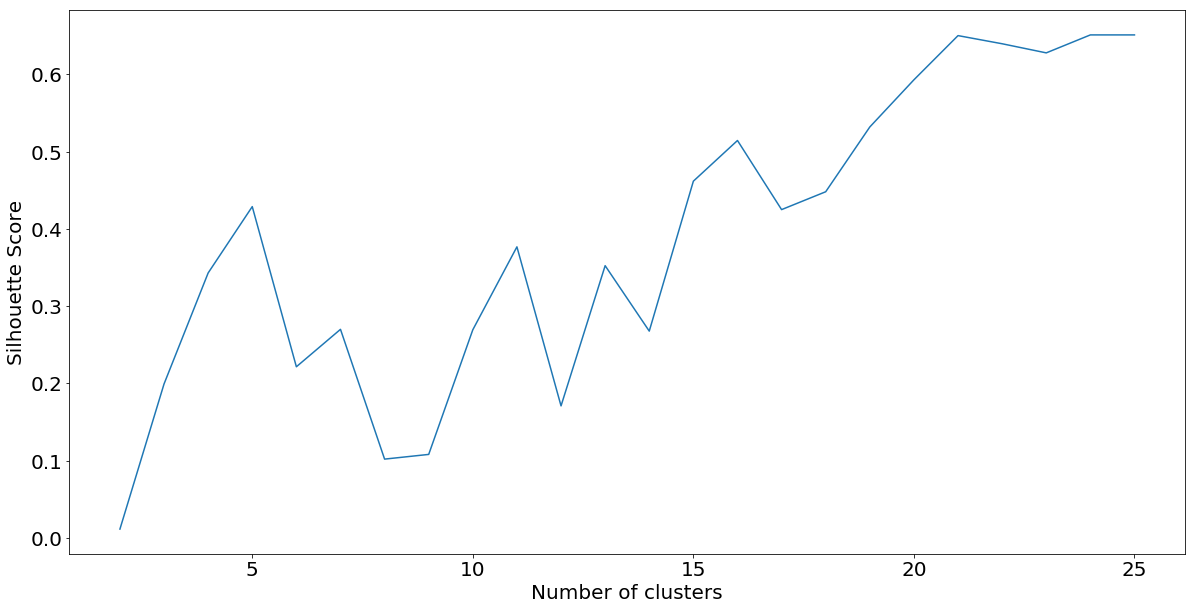

In [51]:
#Creates Silhouette Score for GMM
sc_evaluate_clusters_gmm(Feature_vector_post911['post911_Weapons'].tolist(),25) 

In [52]:
# Creates gmm fit, labeling, and centroids
gmm = mixture.GaussianMixture(n_components=22, covariance_type='full')
gmm.fit(Feature_vector_post911['post911_Weapons'].tolist())

gmm_labels_post911 = gmm.predict(Feature_vector_post911['post911_Weapons'].tolist())
gmm_centroids_post911 = gmm.means_

Feature_vector_post911['gmm_label_post911'] = gmm_labels_post911

In [53]:
gmm_count = np.zeros(shape=(max(gmm_labels_post911)+1,len(weapons_list)))
for i in range(len(gmm_labels_post911)):
    gmm_count[gmm_labels_post911[i]] = gmm_count[gmm_labels_post911[i]] + Feature_vector_post911['post911_Weapons'][i]

gmm_legend_post911 = []
for m in gmm_count:
    max_index = [i for i, j in enumerate(m) if j == max(m)]
    gmm_legend_post911.append(weapons_list[max_index[0]])

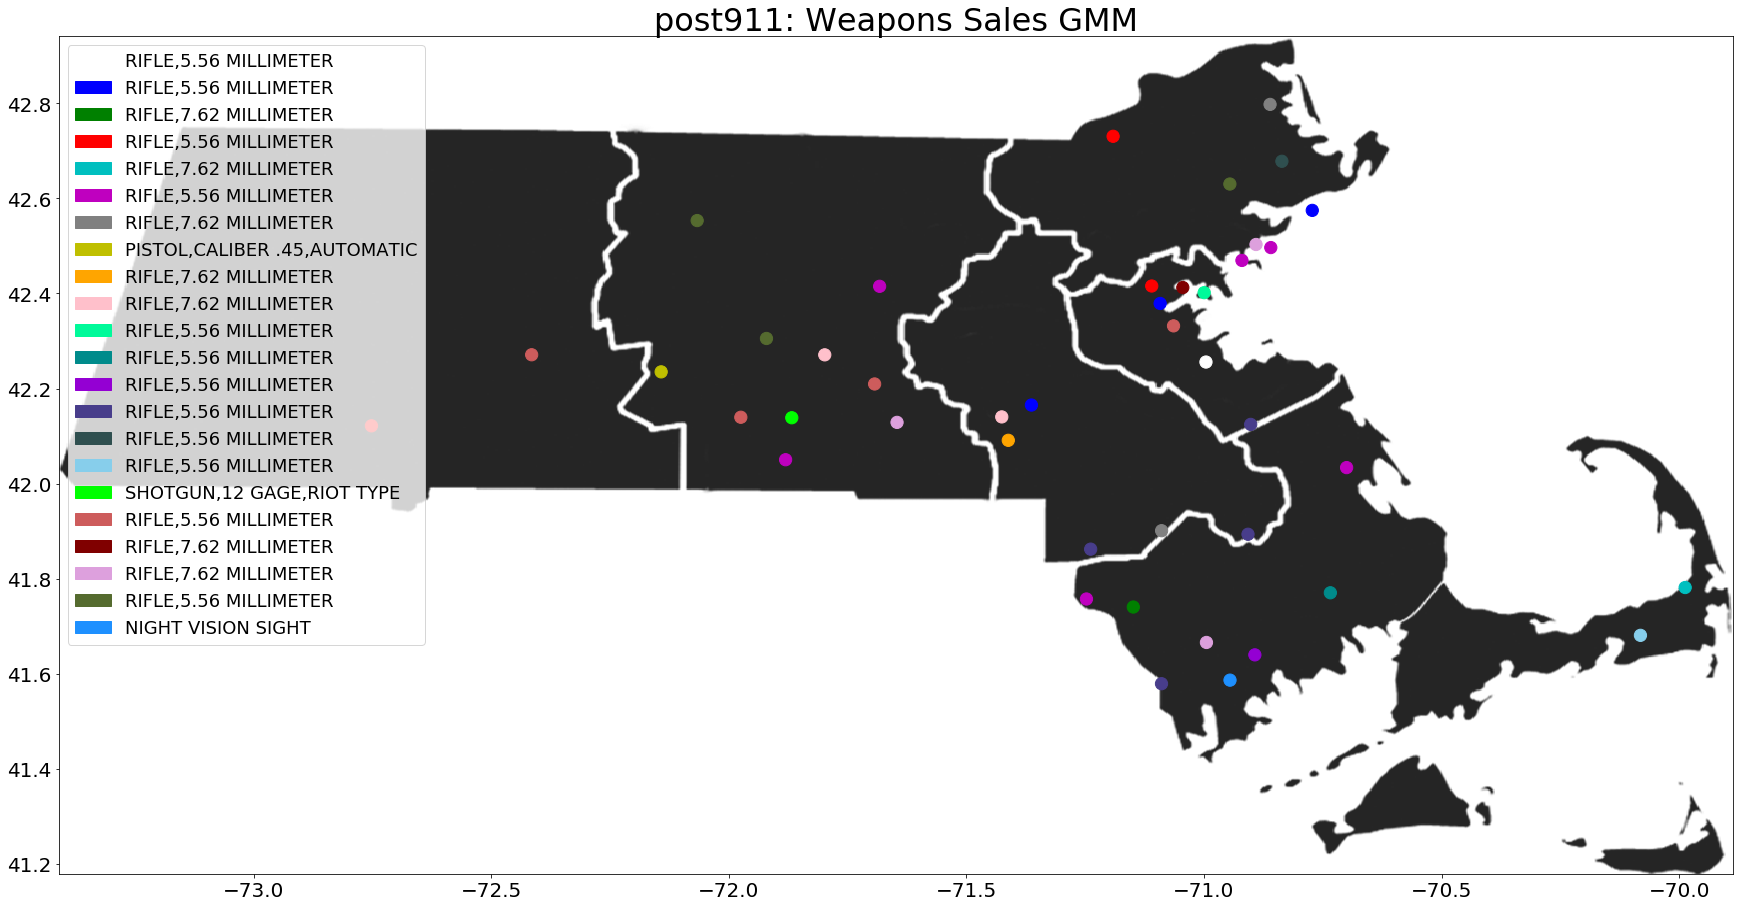

In [54]:
# Generates Cluster Graph
fig, ax = plt.subplots()
img =plt.imread('massachusetts.png')
ax.imshow(img,extent=[min(Feature_vector.longitude)-.2,max(Feature_vector.longitude)+.1,min(Feature_vector.latitude)-.4,max(Feature_vector.latitude)+.1])

plt.title('post911: Weapons Sales GMM', {'fontsize':32})
plt.rcParams["figure.figsize"] = (30,20)
plt.xticks(size=20)
plt.yticks(size=20)
cols = [matplotlib_colors[p] for p in Feature_vector_post911['gmm_label_post911']]
plt.scatter(Feature_vector_post911['longitude'], Feature_vector_post911['latitude'], s=150, c=cols)

gmm_handles_post911 = []
for i in range(0,len(gmm_legend_post911)):
    clusternum = 'cluster' + str(i)
    line = clusternum + ' = pat.Patch(color =  matplotlib_colors[' + str(i) + '], label = gmm_legend_post911[' + str(i) + '])'
    exec(line)
    gmm_handles_post911.append(eval(clusternum))

plt.legend(handles = gmm_handles_post911, prop={'size': 18})
plt.show()
fig.savefig('Post911_GMM.png')

## 2010+

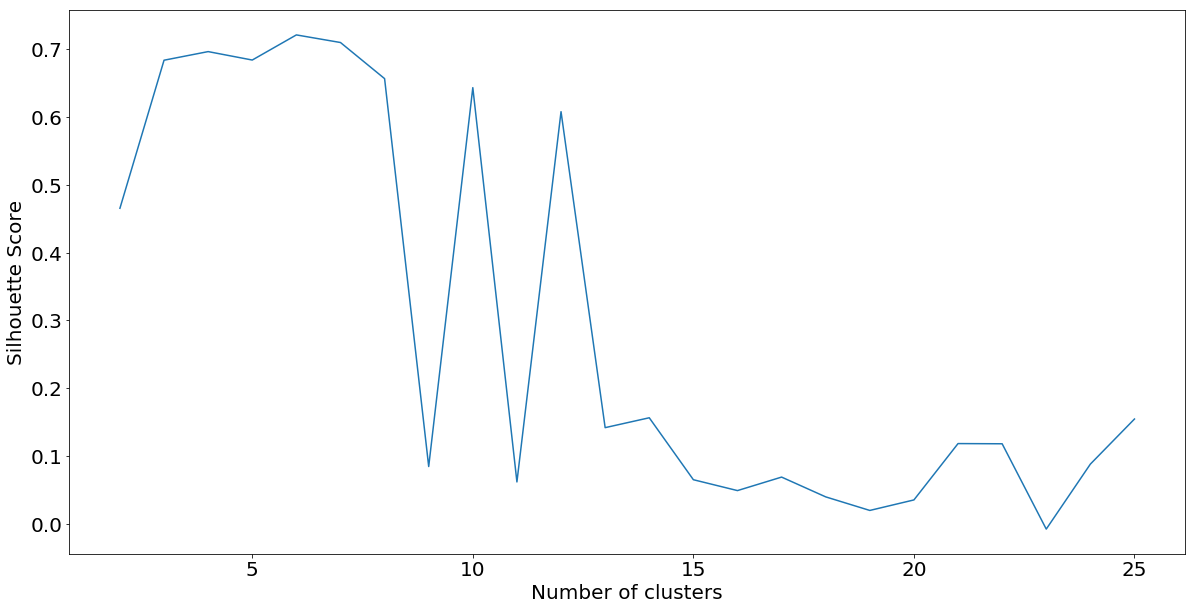

In [55]:
#Creates Silhouette Score for GMM
sc_evaluate_clusters_gmm(Feature_vector_plus2010['plus2010_Weapons'].tolist(),25) 

In [56]:
# Creates gmm fit, labeling, and centroids
gmm = mixture.GaussianMixture(n_components=7, covariance_type='full')
gmm.fit(Feature_vector_plus2010['plus2010_Weapons'].tolist())

gmm_labels_plus2010 = gmm.predict(Feature_vector_plus2010['plus2010_Weapons'].tolist())
gmm_centroids_plus2010 = gmm.means_

Feature_vector_plus2010['gmm_label_plus2010'] = gmm_labels_plus2010

In [57]:
gmm_count = np.zeros(shape=(max(gmm_labels_plus2010)+1,len(weapons_list)))
for i in range(len(gmm_labels_plus2010)):
    gmm_count[gmm_labels_plus2010[i]] = gmm_count[gmm_labels_plus2010[i]] + Feature_vector_plus2010['plus2010_Weapons'][i]

gmm_legend_plus2010 = []
for m in gmm_count:
    max_index = [i for i, j in enumerate(m) if j == max(m)]
    gmm_legend_plus2010.append(weapons_list[max_index[0]])

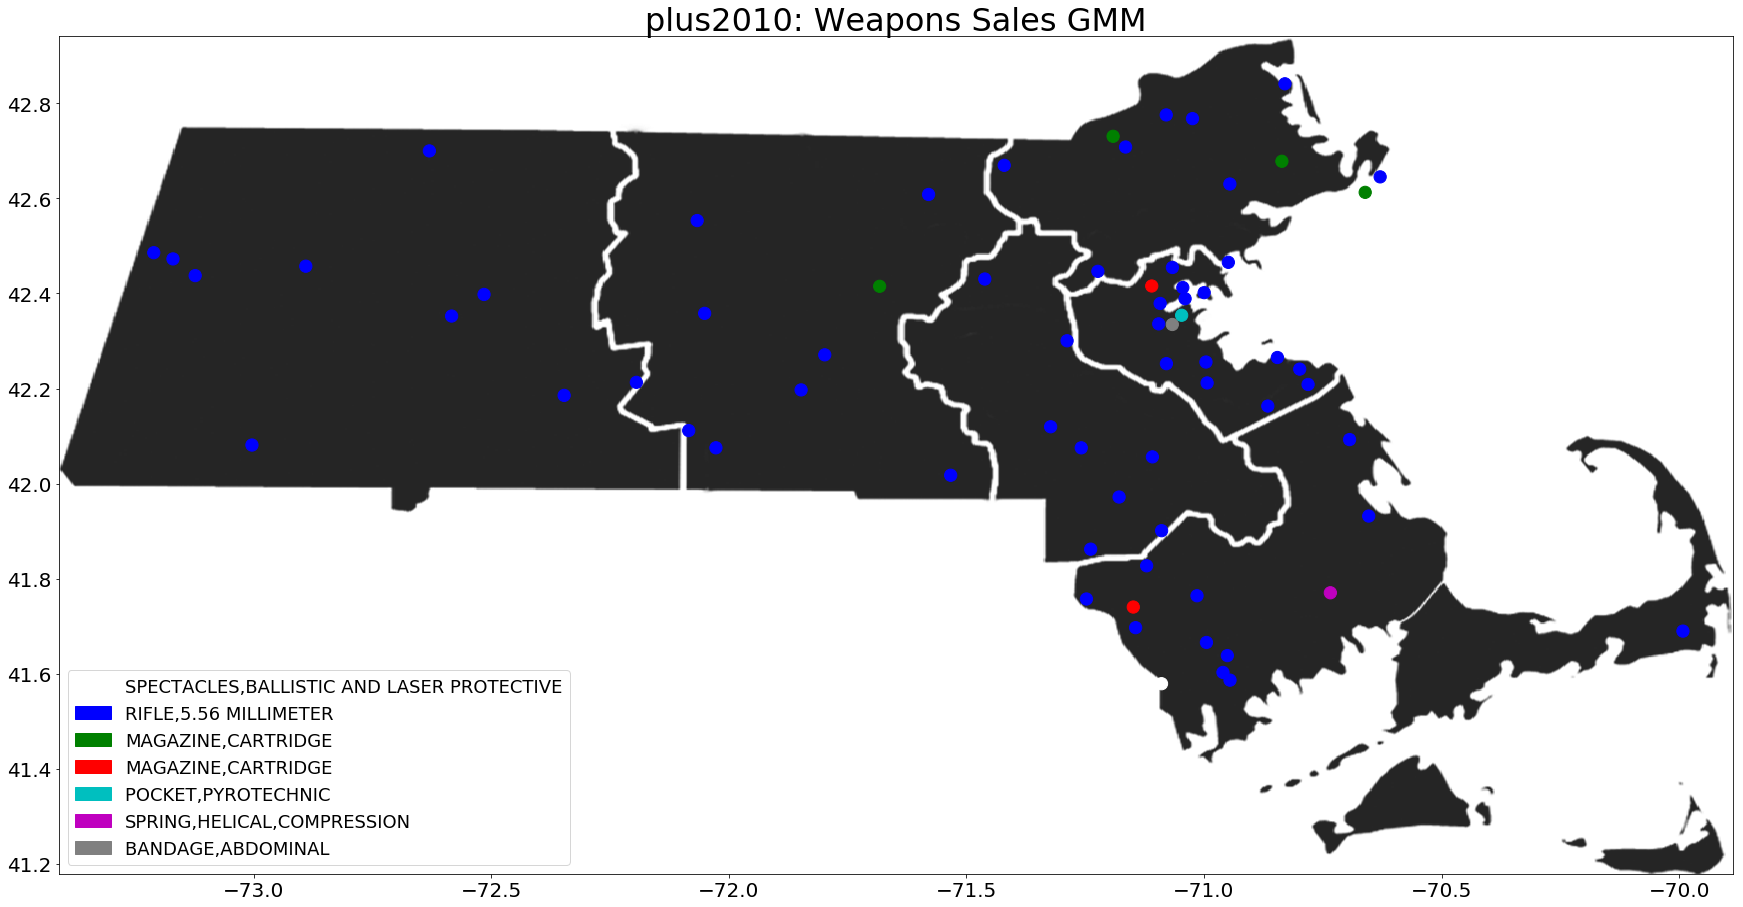

In [58]:
# Generates Cluster Graph
fig, ax = plt.subplots()
img =plt.imread('massachusetts.png')
ax.imshow(img,extent=[min(Feature_vector.longitude)-.2,max(Feature_vector.longitude)+.1,min(Feature_vector.latitude)-.4,max(Feature_vector.latitude)+.1])

plt.title('plus2010: Weapons Sales GMM', {'fontsize':32})
plt.rcParams["figure.figsize"] = (30,20)
plt.xticks(size=20)
plt.yticks(size=20)
cols = [matplotlib_colors[p] for p in Feature_vector_plus2010['gmm_label_plus2010']]
plt.scatter(Feature_vector_plus2010['longitude'], Feature_vector_plus2010['latitude'], s=150, c=cols)

gmm_handles_plus2010 = []
for i in range(0,len(gmm_legend_plus2010)):
    clusternum = 'cluster' + str(i)
    line = clusternum + ' = pat.Patch(color =  matplotlib_colors[' + str(i) + '], label = gmm_legend_plus2010[' + str(i) + '])'
    exec(line)
    gmm_handles_plus2010.append(eval(clusternum))

plt.legend(handles = gmm_handles_plus2010, prop={'size': 18})
plt.show()
fig.savefig('2010plus_GMM.png')